In [1]:
%load_ext autoreload
%autoreload 2

# Normalize and train

This notebook will use the KuHar view and will:

1. Fit the standard scaler (normalizer) over train dataset
2. Normalize the train and test datasets
3. Apply DFT over dataset windows
4. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
5. Plot UMAP and T-SNE

In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from librep.datasets.har.loaders import KuHarResampledView20HZ
from librep.datasets.multimodal import TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.transforms.resampler import SimpleResampler
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport

2022-09-26 16:52:13.685883: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-26 16:52:13.685960: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
def do_resample(train_dataset, test_dataset, new_sample_size=60):
    resampler = SimpleResampler(new_sample_size=60)
    transformer = TransformMultiModalDataset(
        transforms=[resampler], new_window_name_prefix="resampled."
    )
    train_dataset = transformer(train_dataset)
    test_dataset = transformer(test_dataset)
    return train_dataset, test_dataset


def transform_dataset(train_dataset, test_dataset, normalize: bool = "before"):
    assert normalize in ["after", "before", None], "Invalid normalize value"
    if normalize is None:
        normalize = ""

    if normalize == "before":
        train_scaler = StandardScaler()
        train_scaler.fit(train_dataset[:][0])

        # Create the objects
        scaler_transform = WindowedTransform(
            transform=train_scaler, fit_on=None, transform_on="all"
        )
        fft_transform = FFT()

        # Compose the transform
        # First apply the normalizer over whole dataset and then apply FFT over each window
        transformer = TransformMultiModalDataset(
            transforms=[scaler_transform, fft_transform],
            new_window_name_prefix="scaled.fft."
        )

        # Transform it and generate a new dataset!
        train_scaled_fft = transformer(train_dataset)
        test_scaled_fft = transformer(test_dataset)

        return train_scaled_fft, test_scaled_fft

    else: # after of None
        fft_transform = FFT()

        # Compose the transform
        # First apply the normalizer over whole dataset and then apply FFT over each window
        transformer = TransformMultiModalDataset(
            transforms=[fft_transform],
            new_window_name_prefix="fft."
        )

        # Transform it and generate a new dataset!
        train_fft = transformer(train_dataset)
        test_fft = transformer(test_dataset)

        if normalize == "":
            # Just return it. FFT is already applyied
            return train_fft, test_fft

        else:
            train_scaler = StandardScaler()
            train_scaler.fit(train_fft[:][0])

            scaler_transform = WindowedTransform(
                transform=train_scaler, fit_on=None, transform_on="all"
            )
            # Compose the transform
            # First apply the normalizer over whole dataset and then apply FFT over each window
            transformer = TransformMultiModalDataset(
                transforms=[scaler_transform],
                new_window_name_prefix="scaled."
            )

            # Transform it and generate a new dataset!
            train_fft_scaled = transformer(train_fft)
            test_fft_scaled = transformer(test_fft)

            return train_fft_scaled, test_fft_scaled


def evaluate_dataset(train_dataset, test_dataset):
    def get_average(result):
        mean_acc = np.average([res["result"][0]["accuracy"] for res in result["runs"]])
        mean_f1 = np.average(
            [res["result"][0]["f1 score (weighted)"] for res in result["runs"]]
        )
        return mean_acc, mean_f1

    reporter = ClassificationReport(
        use_accuracy=True,
        use_f1_score=True,
        use_classification_report=False,
        use_confusion_matrix=False,
        plot_confusion_matrix=True,
    )

    #### Random forest
    experiment = SimpleTrainEvalWorkflow(
        estimator=RandomForestClassifier,
        do_not_instantiate=False,
        do_fit=True,
        evaluator=reporter,
    )

    print("----------------- Random Forest -----------------")

    multi_run_experiment = MultiRunWorkflow(
        workflow=experiment, num_runs=3, debug=False
    )
    results = multi_run_experiment(train_dataset, [test_dataset])
    mean_acc, mean_f1 = get_average(results)
    print(
        f"[RandomForest] Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}\n"
    )

    ### SVM
    experiment = SimpleTrainEvalWorkflow(
        estimator=SVC,
        do_not_instantiate=False,
        do_fit=True,
        evaluator=reporter,
    )

    print("----------------- SVM -----------------")
    multi_run_experiment = MultiRunWorkflow(
        workflow=experiment, num_runs=3, debug=False
    )
    results = multi_run_experiment(train_dataset, [test_dataset])
    mean_acc, mean_f1 = get_average(results)
    print(
        f"[SVM] Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}\n"
    )

    # KNN
    experiment = SimpleTrainEvalWorkflow(
        estimator=KNeighborsClassifier,
        do_not_instantiate=False,
        do_fit=True,
        evaluator=reporter,
    )

    print("----------------- KNN -----------------")
    multi_run_experiment = MultiRunWorkflow(
        workflow=experiment, num_runs=3, debug=False
    )
    results = multi_run_experiment(train_dataset, [test_dataset])
    mean_acc, mean_f1 = get_average(results)
    print(
        f"[KNN] Mean accuracy (3 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}\n"
    )


def plot(df, figsize: tuple = (12, 12), title: str = None, labels: dict = None):
    fig, ax = plt.subplots(figsize=figsize)
    for label, group_df in df.groupby("label"):
        label = labels[label] if labels is not None else label
        ax.scatter(group_df.x, group_df.y, label=label)
    ax.legend()
    plt.title(title)
    plt.show()


def project(dataset, name: str, labels: dict = None):
    model = UMAP(n_components=2)
    result = pd.DataFrame(model.fit_transform(dataset[:][0]), columns=["x", "y"])
    result["label"] = dataset[:][1]
    plot(result, title=f"UMAP on {name}", labels=labels)

    model = TSNE(n_components=2)
    result = pd.DataFrame(
        model.fit_transform(train_val_fft_scaled[:][0]), columns=["x", "y"]
    )
    result["label"] = dataset[:][1]
    plot(result, title=f"T-SNE on {name}", labels=labels)

## KuHAR 20HZ (Normalization + FFT)

----------------- Random Forest -----------------


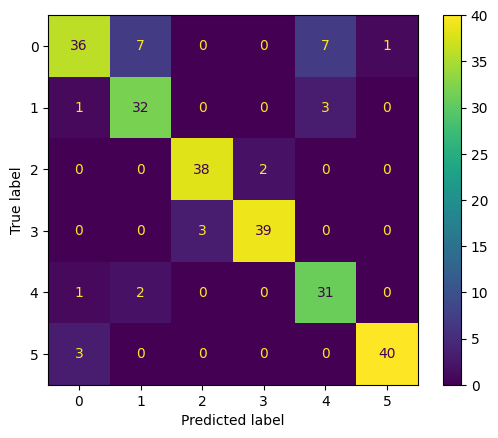

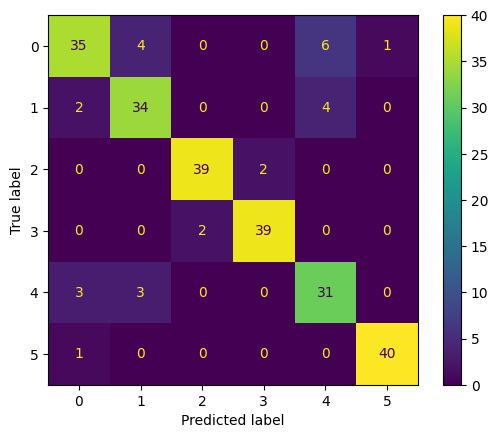

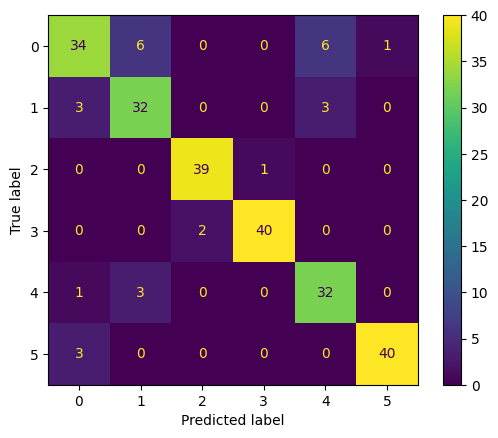

[RandomForest] Mean accuracy (3 runs): 0.8821. Mean f1-score: 0.8819

----------------- SVM -----------------


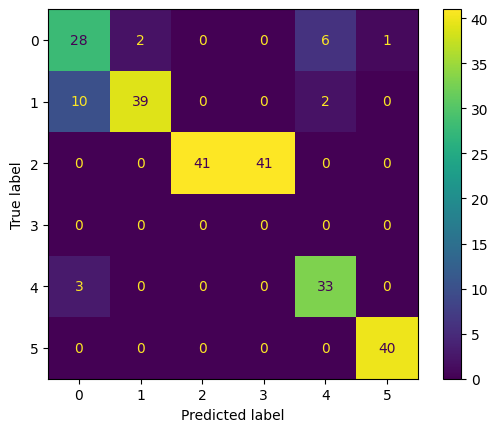

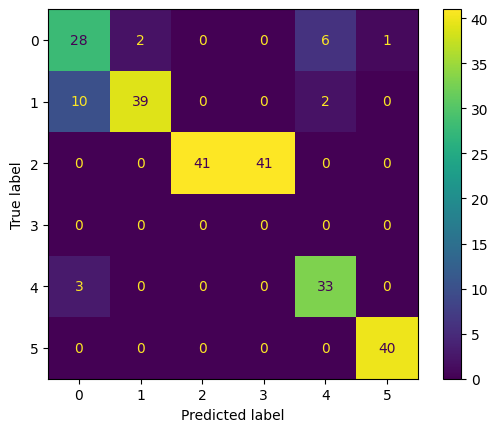

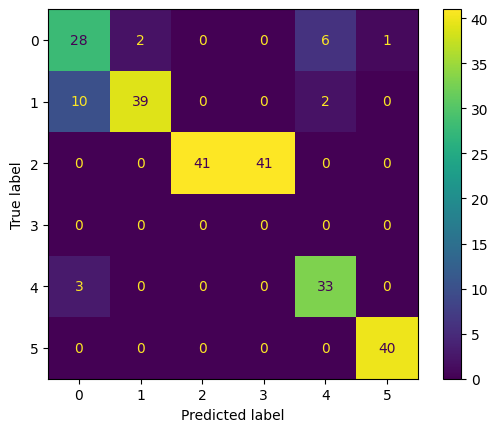

[SVM] Mean accuracy (3 runs): 0.7358. Mean f1-score: 0.7920

----------------- KNN -----------------


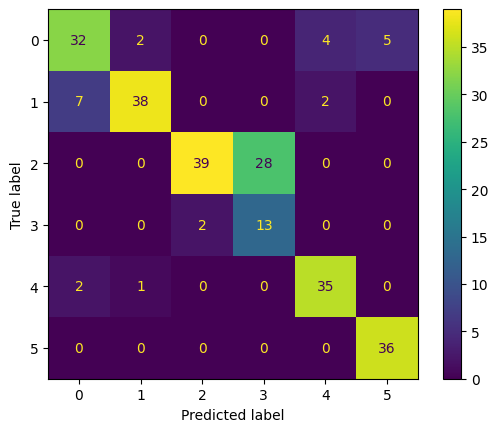

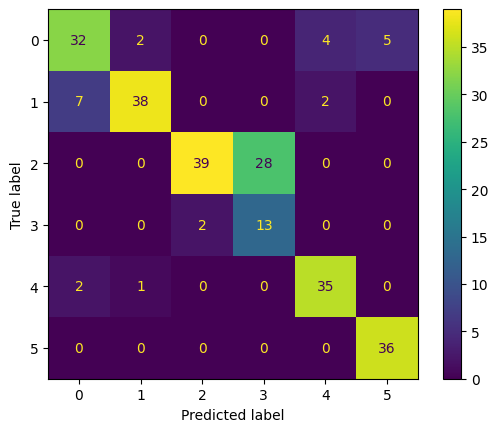

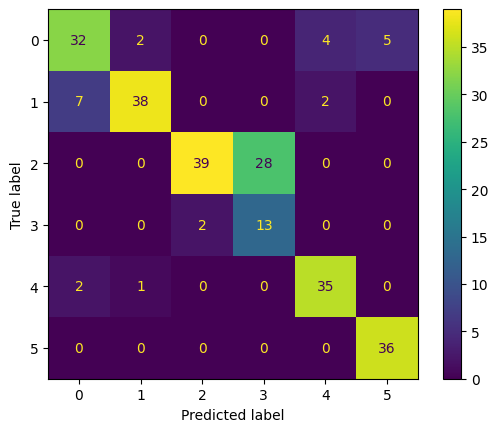

[KNN] Mean accuracy (3 runs): 0.7846. Mean f1-score: 0.7969



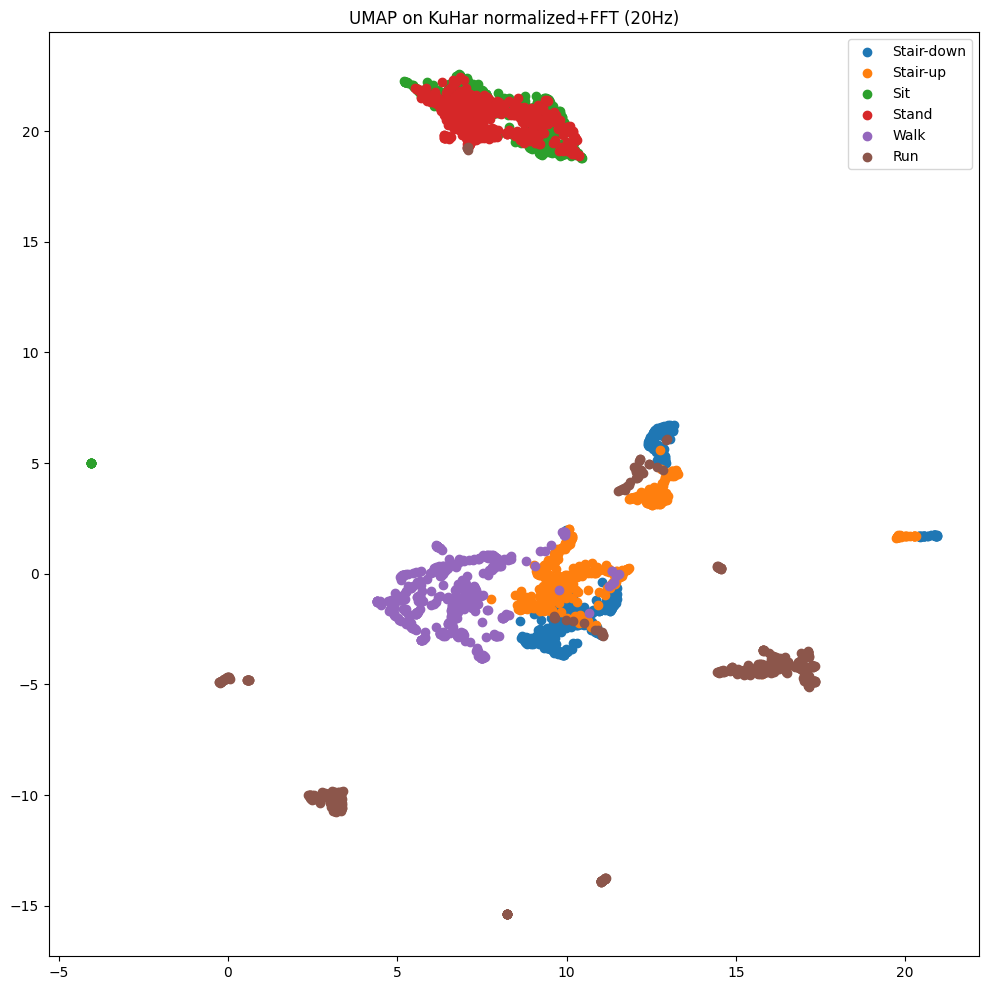

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


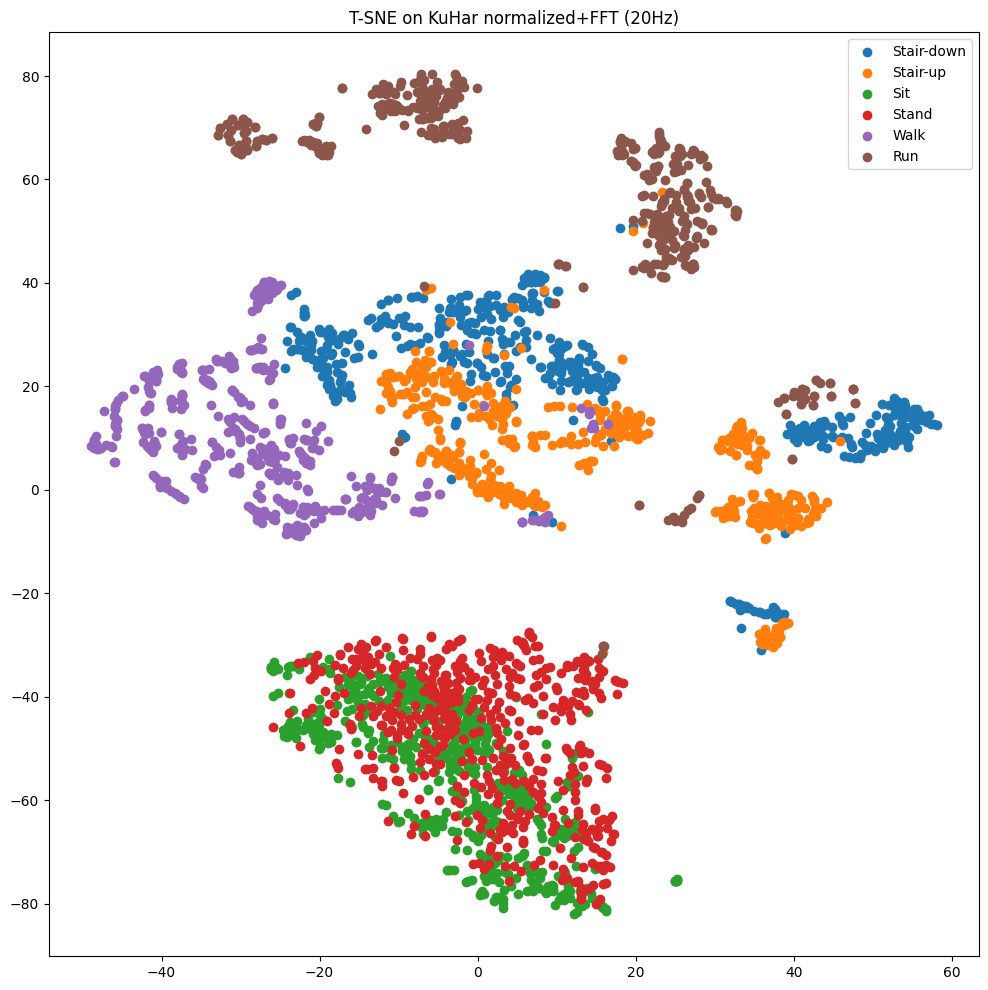

In [5]:
from librep.datasets.har.loaders import KuHarResampledView20HZ
activities = {
    0: "Stair-down",
    1: "Stair-up",
    2: "Sit",
    3: "Stand",
    4: "Walk",
    5: "Run"
}
loader = KuHarResampledView20HZ("../data/views/KuHar/balanced_motionsense_equivalent_view", download=False)
train_val, test = loader.load(concat_train_validation=True)
train_val, test = do_resample(train_val, test)

train_val_fft_scaled, test_fft_scaled = transform_dataset(train_val, test, normalize="before")
evaluate_dataset(train_val_fft_scaled, test_fft_scaled)
project(train_val_fft_scaled, "KuHar normalized+FFT (20Hz)", labels=activities)

# KuHar 20Hz (FFT + Normalization)

----------------- Random Forest -----------------


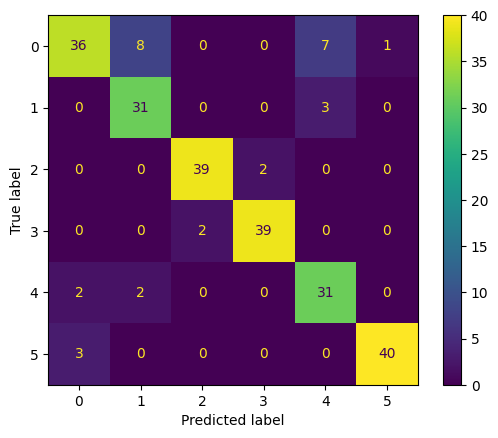

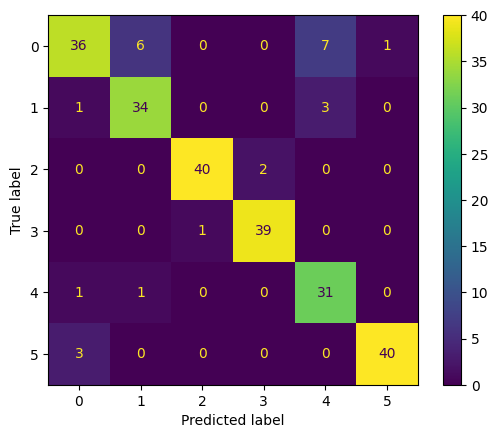

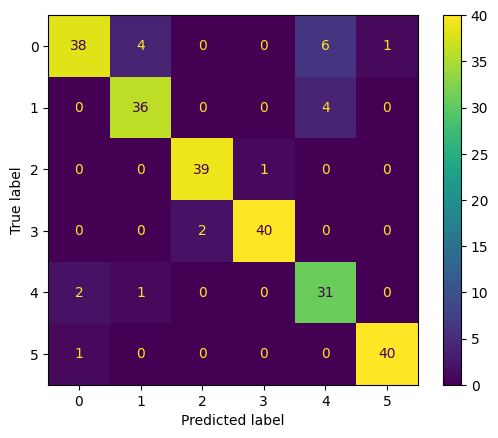

[RandomForest] Mean accuracy (3 runs): 0.8943. Mean f1-score: 0.8940

----------------- SVM -----------------


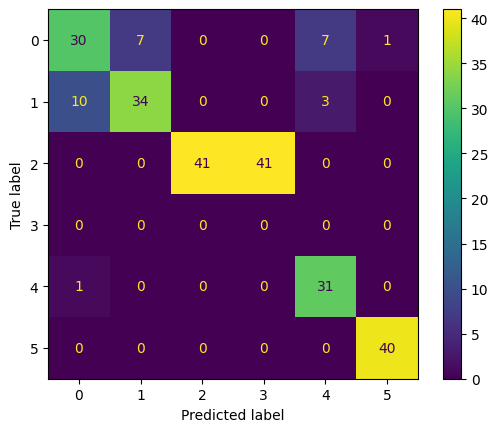

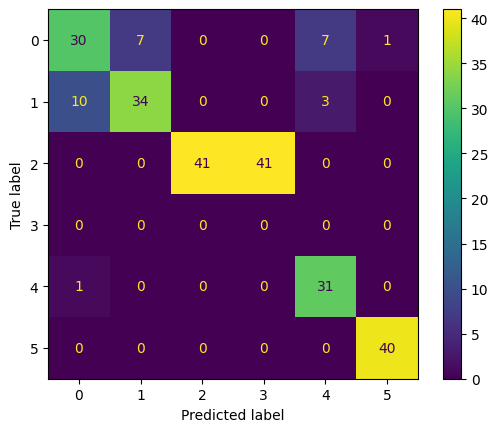

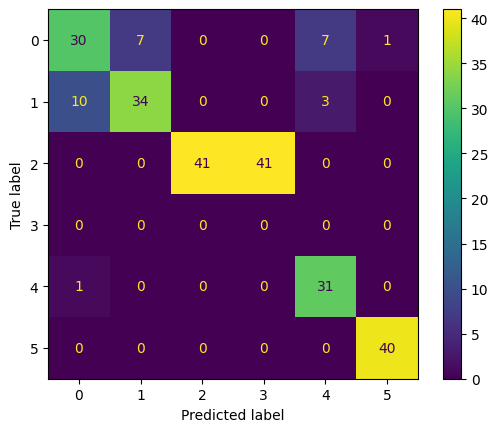

[SVM] Mean accuracy (3 runs): 0.7154. Mean f1-score: 0.7686

----------------- KNN -----------------


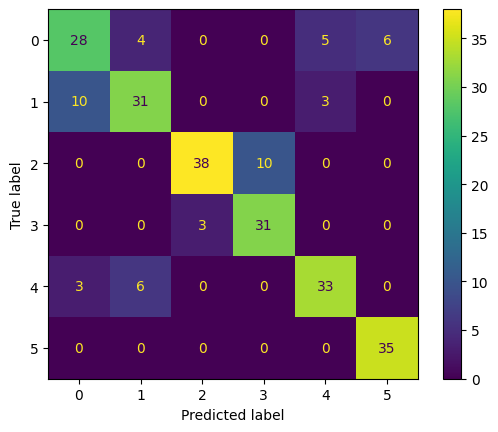

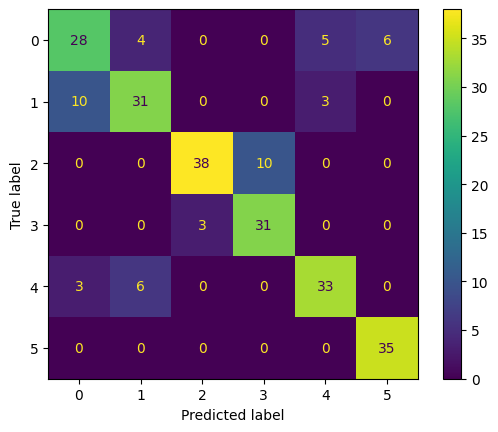

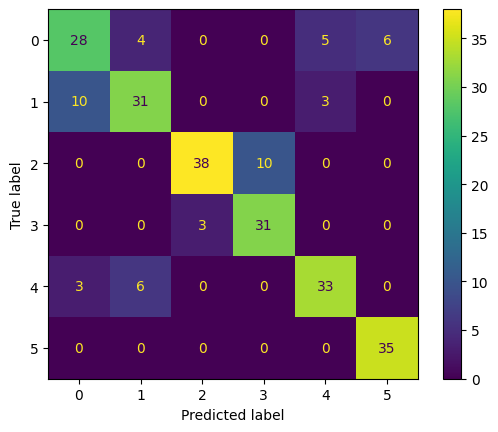

[KNN] Mean accuracy (3 runs): 0.7967. Mean f1-score: 0.7947



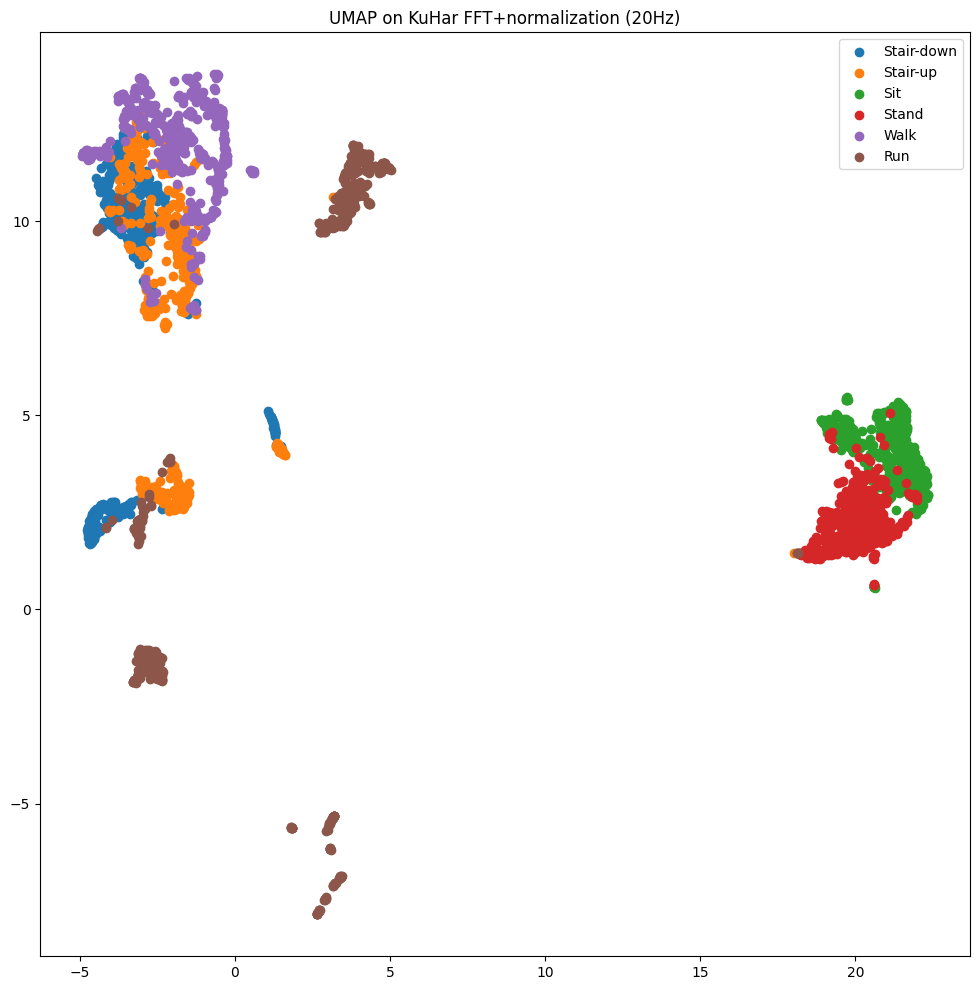

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


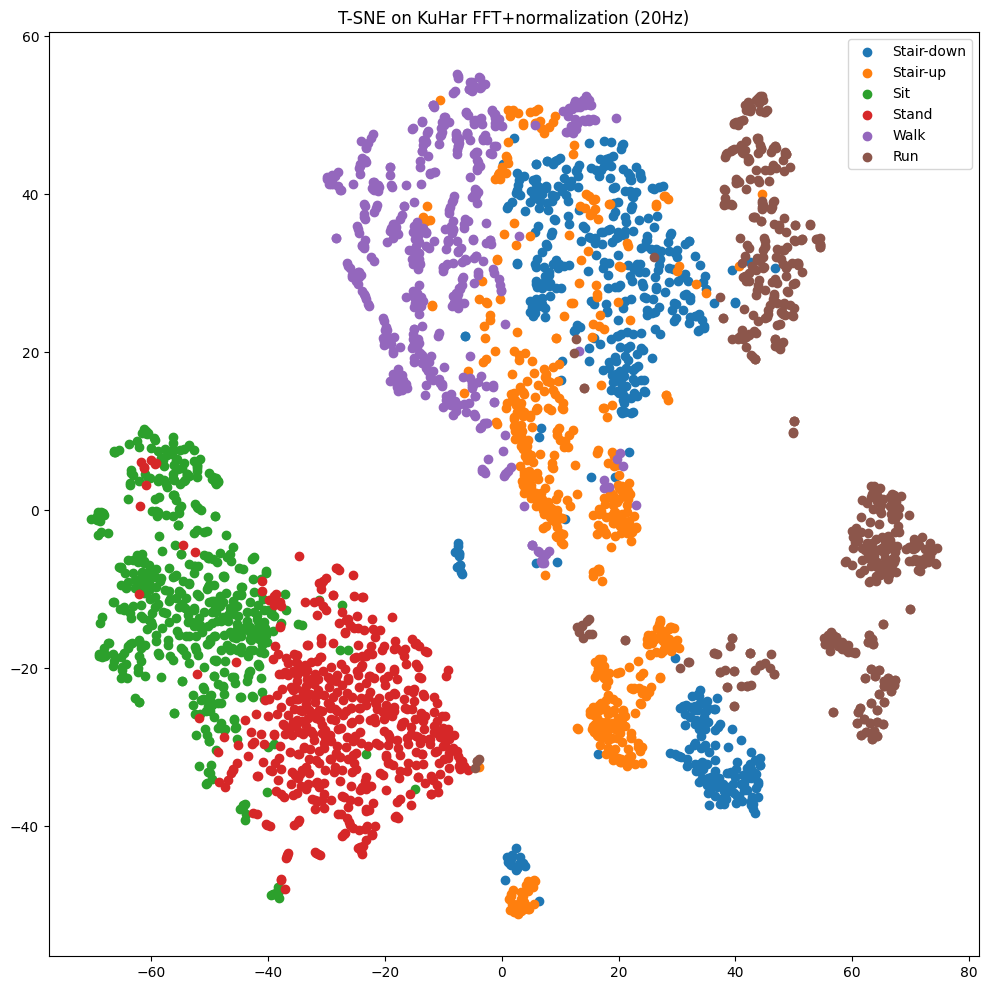

In [6]:
from librep.datasets.har.loaders import KuHarResampledView20HZ
activities = {
    0: "Stair-down",
    1: "Stair-up",
    2: "Sit",
    3: "Stand",
    4: "Walk",
    5: "Run"
}
loader = KuHarResampledView20HZ("../data/views/KuHar/balanced_motionsense_equivalent_view", download=False)
train_val, test = loader.load(concat_train_validation=True)
train_val, test = do_resample(train_val, test)

train_val_fft_scaled, test_fft_scaled = transform_dataset(train_val, test, normalize="after")
evaluate_dataset(train_val_fft_scaled, test_fft_scaled)
project(train_val_fft_scaled, "KuHar FFT+normalization (20Hz)", labels=activities)

## KuHar (FFT only)

----------------- Random Forest -----------------


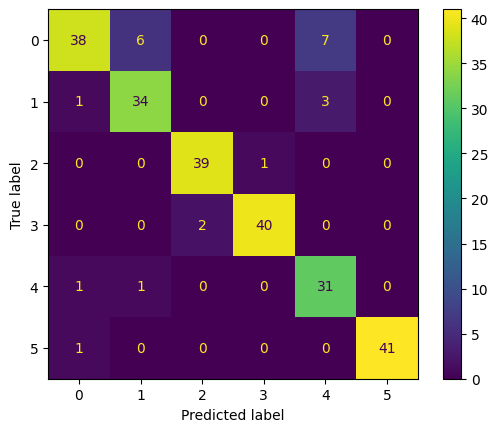

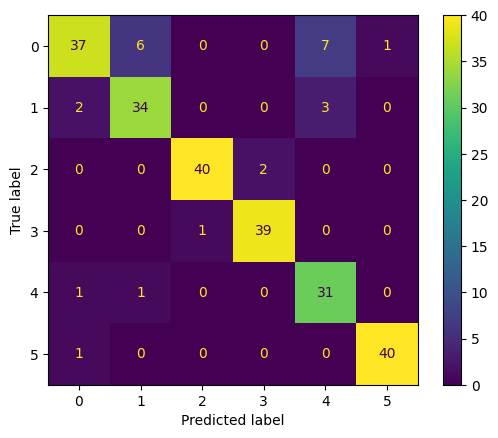

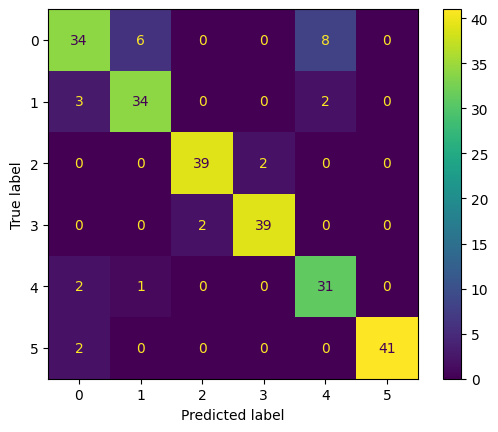

[RandomForest] Mean accuracy (3 runs): 0.8970. Mean f1-score: 0.8966

----------------- SVM -----------------


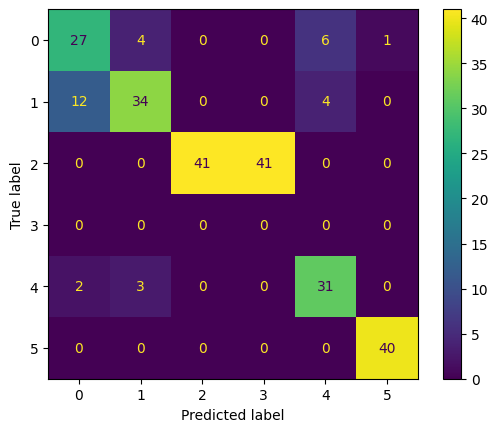

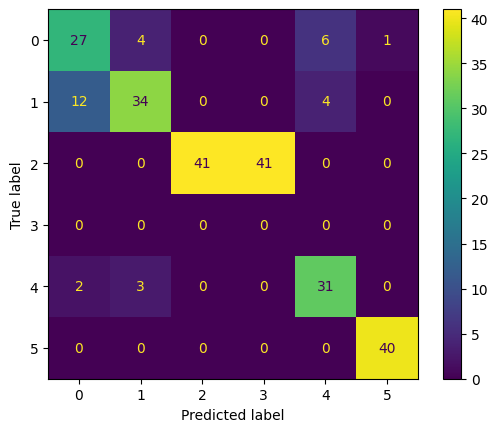

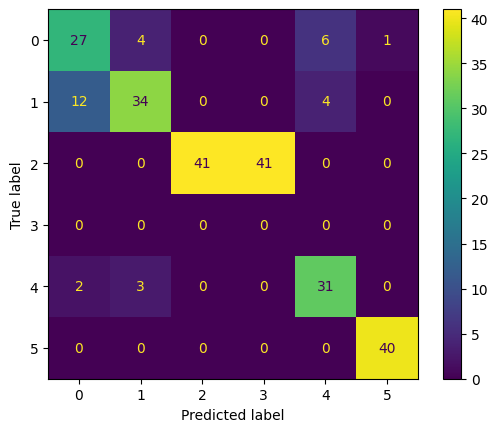

[SVM] Mean accuracy (3 runs): 0.7033. Mean f1-score: 0.7581

----------------- KNN -----------------


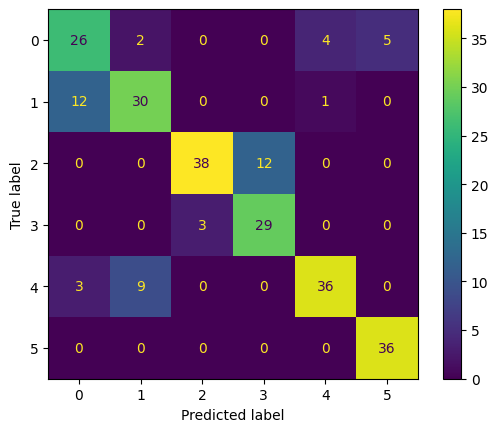

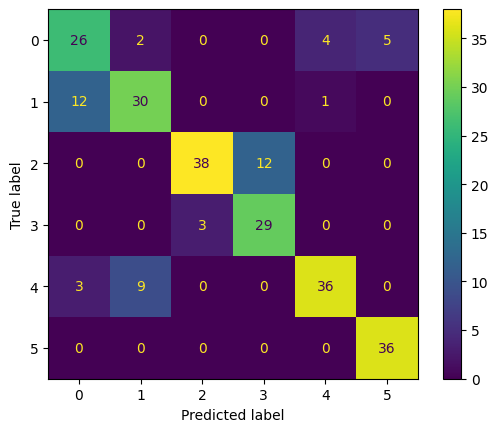

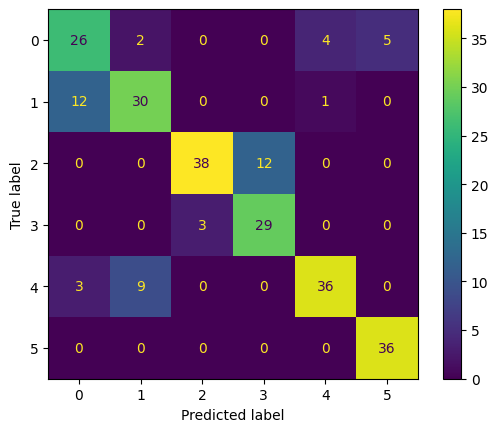

[KNN] Mean accuracy (3 runs): 0.7927. Mean f1-score: 0.7929



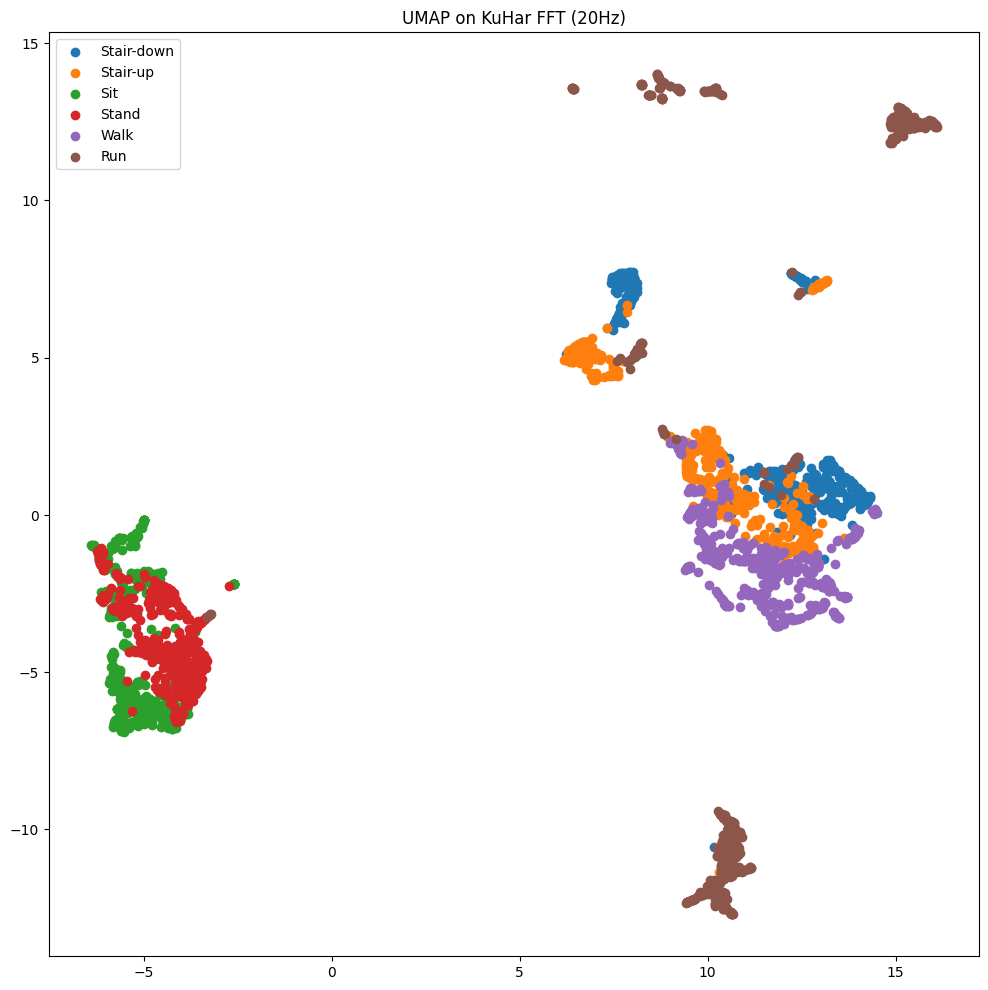

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


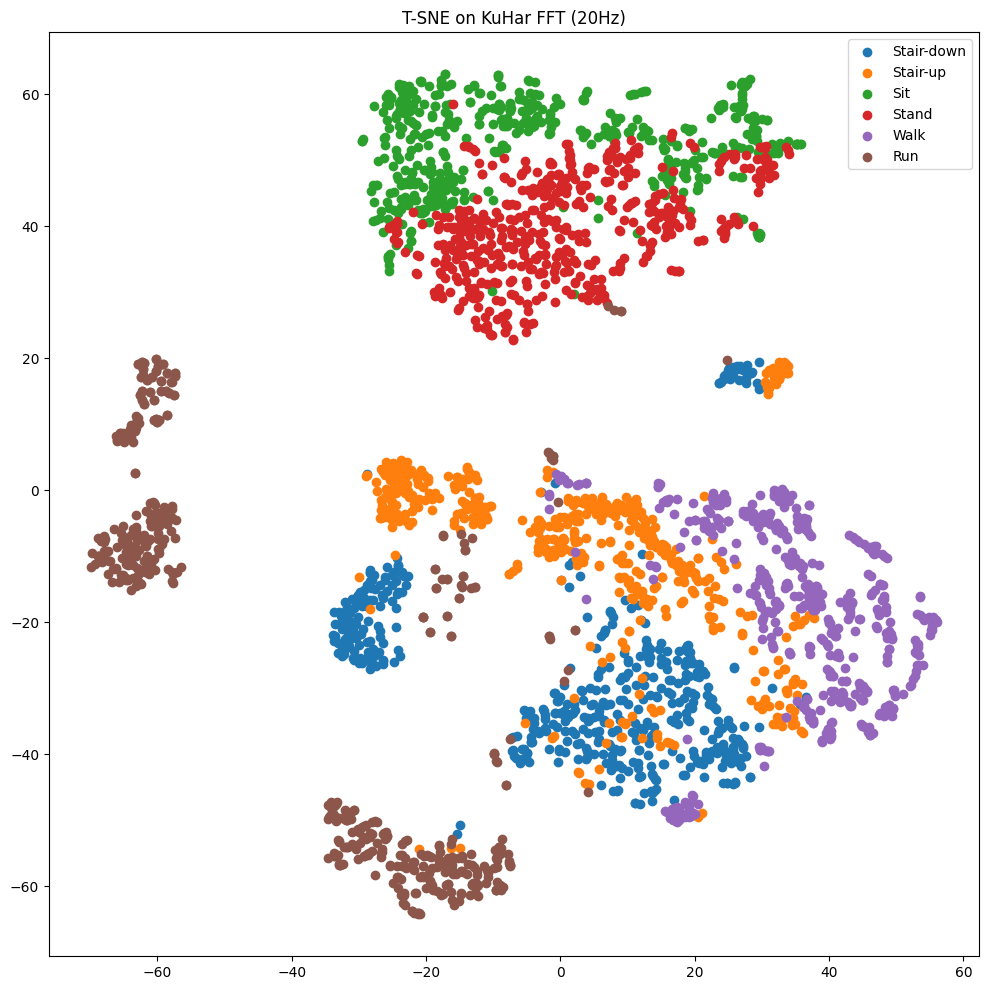

In [7]:
from librep.datasets.har.loaders import KuHarResampledView20HZ
activities = {
    0: "Stair-down",
    1: "Stair-up",
    2: "Sit",
    3: "Stand",
    4: "Walk",
    5: "Run"
}
loader = KuHarResampledView20HZ("../data/views/KuHar/balanced_motionsense_equivalent_view", download=False)
train_val, test = loader.load(concat_train_validation=True)
train_val, test = do_resample(train_val, test)

train_val_fft_scaled, test_fft_scaled = transform_dataset(train_val, test, normalize=None)
evaluate_dataset(train_val_fft_scaled, test_fft_scaled)
project(train_val_fft_scaled, "KuHar FFT (20Hz)", labels=activities)

## MotionSense (normalization + FFT)

----------------- Random Forest -----------------


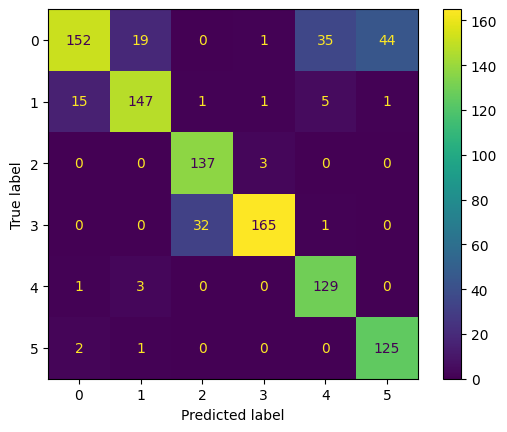

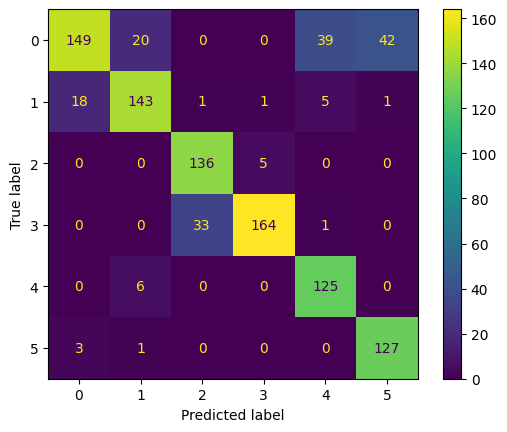

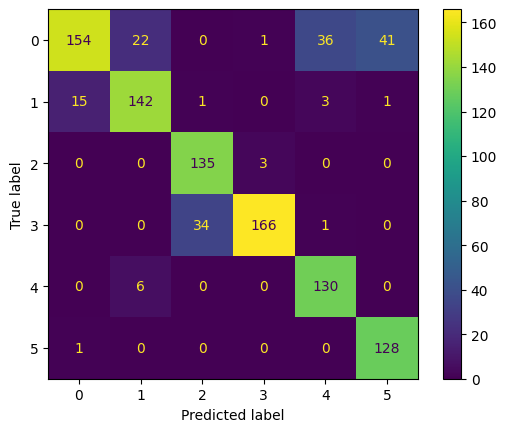

[RandomForest] Mean accuracy (3 runs): 0.8346. Mean f1-score: 0.8298

----------------- SVM -----------------


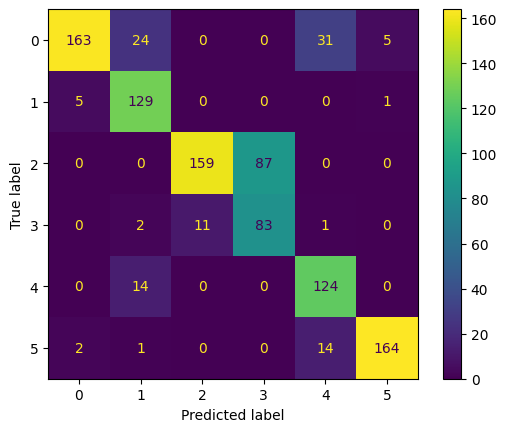

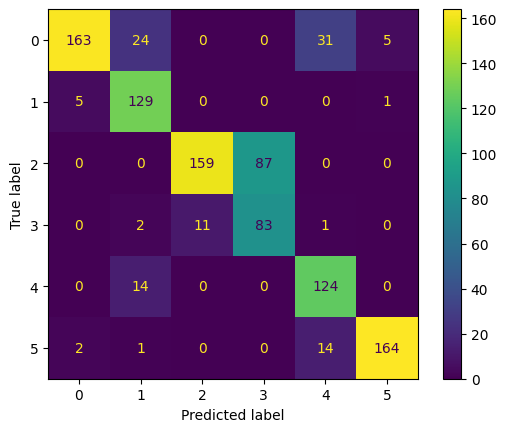

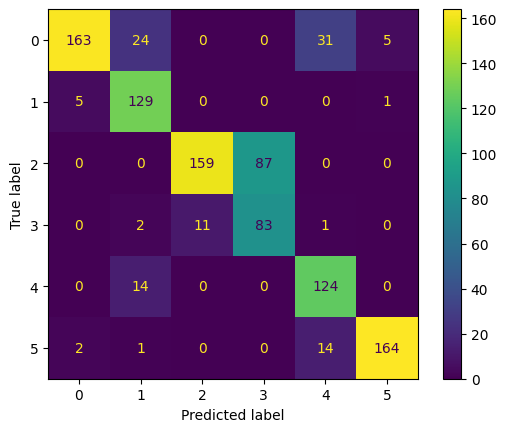

[SVM] Mean accuracy (3 runs): 0.8059. Mean f1-score: 0.8116

----------------- KNN -----------------


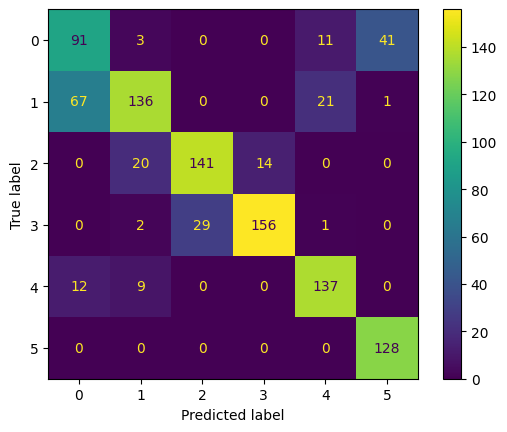

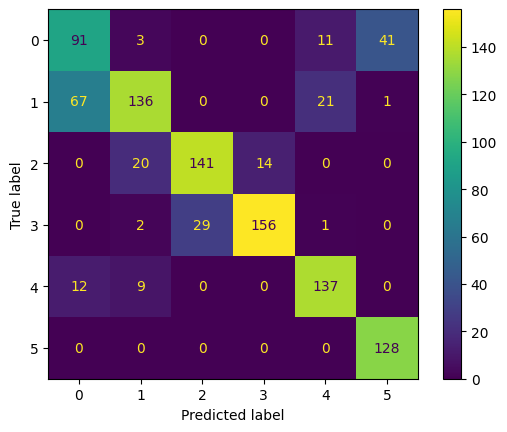

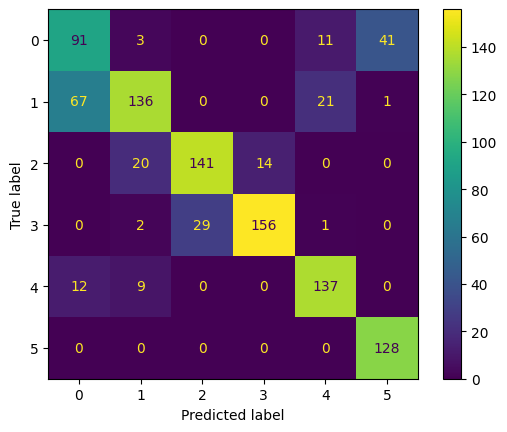

[KNN] Mean accuracy (3 runs): 0.7735. Mean f1-score: 0.7724



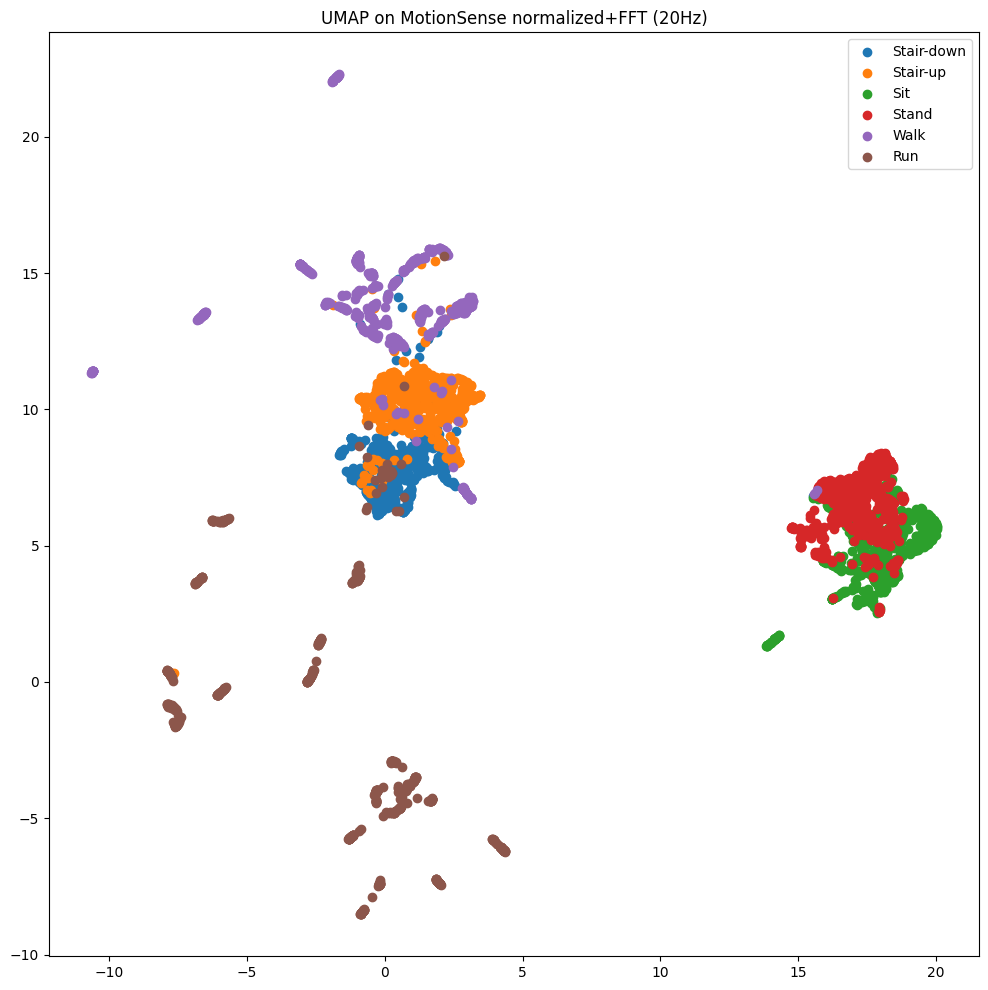

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


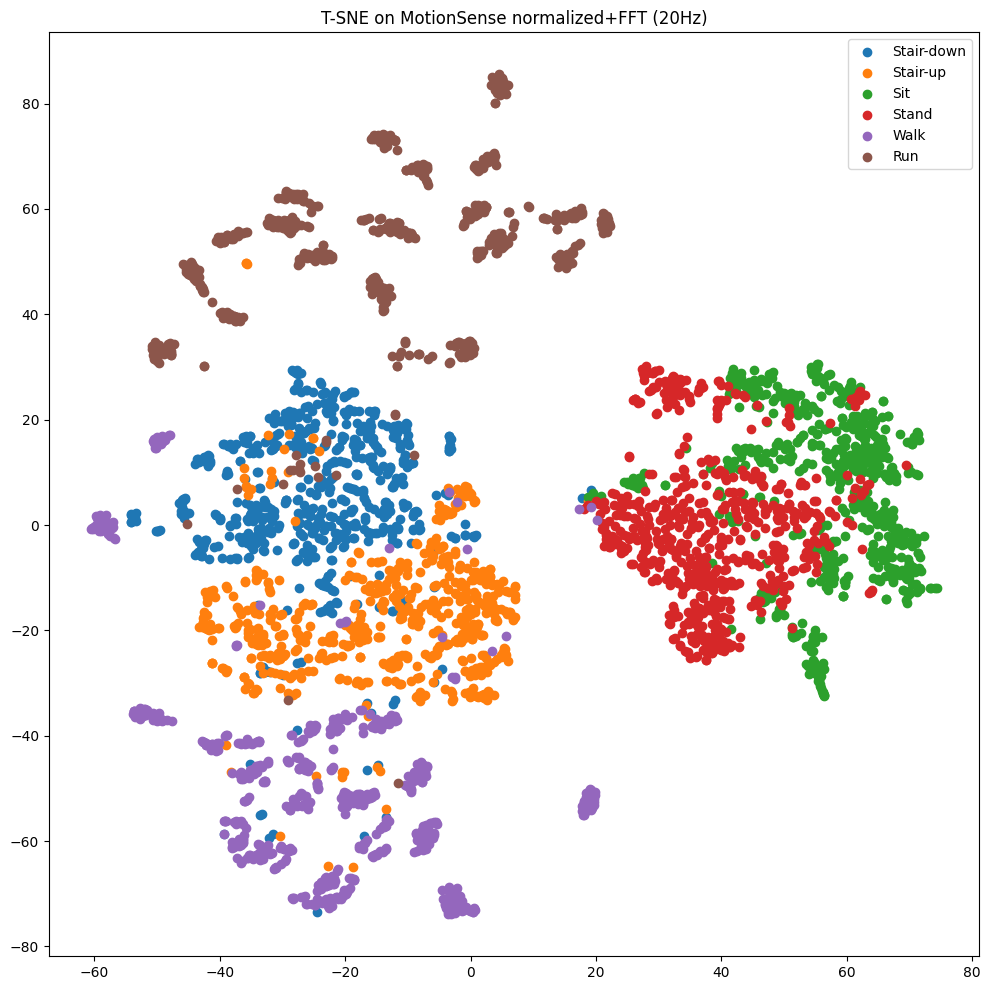

In [8]:
from librep.datasets.har.loaders import MotionSenseResampledView20HZ
activities = {
    0: "Stair-down",
    1: "Stair-up",
    2: "Sit",
    3: "Stand",
    4: "Walk",
    5: "Run"
}

loader = MotionSenseResampledView20HZ(
    "../data/views/MotionSense/resampled_view_20Hz", download=False
)
train_val, test = loader.load(concat_train_validation=True)
# train_val, test = do_resample(train_val, test)

train_val_fft_scaled, test_fft_scaled = transform_dataset(train_val, test, normalize="before")
evaluate_dataset(train_val_fft_scaled, test_fft_scaled)
project(train_val_fft_scaled, "MotionSense normalized+FFT (20Hz)", labels=activities)

## MotionSense (FFT + normalization)

----------------- Random Forest -----------------


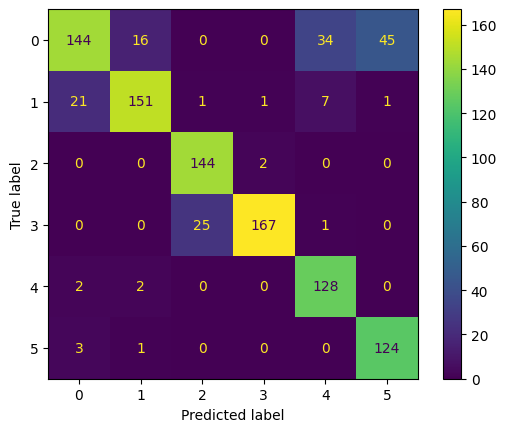

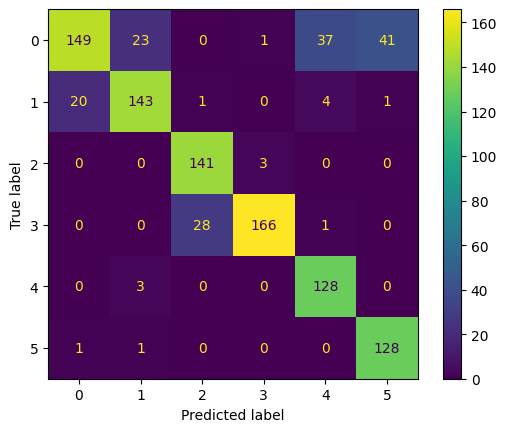

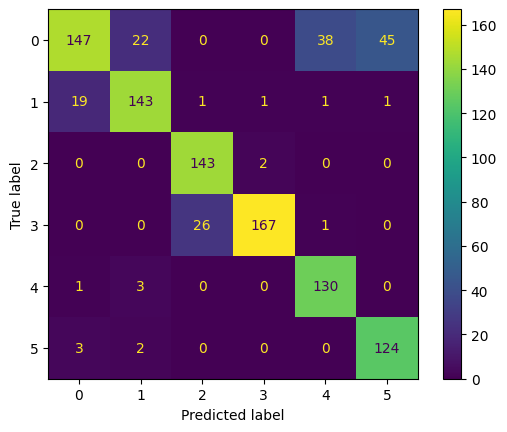

[RandomForest] Mean accuracy (3 runs): 0.8389. Mean f1-score: 0.8336

----------------- SVM -----------------


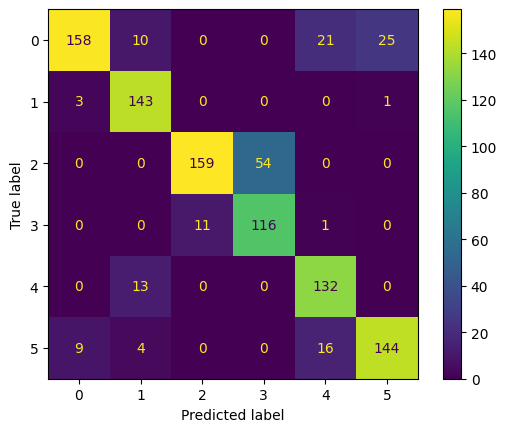

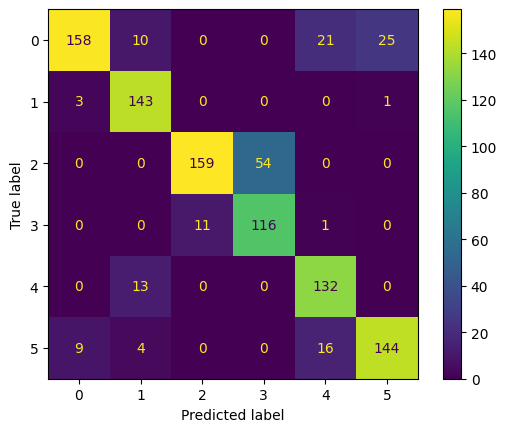

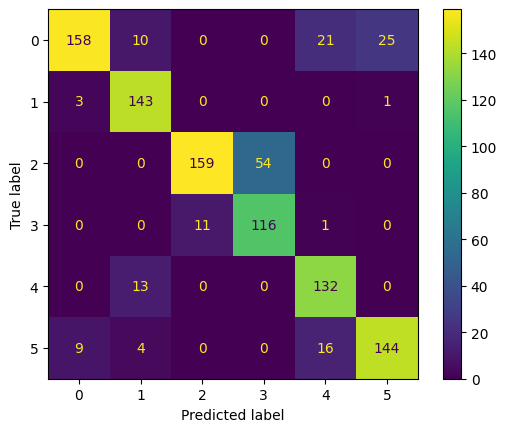

[SVM] Mean accuracy (3 runs): 0.8353. Mean f1-score: 0.8353

----------------- KNN -----------------


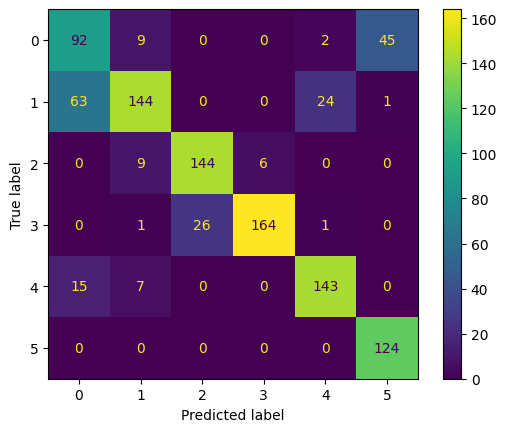

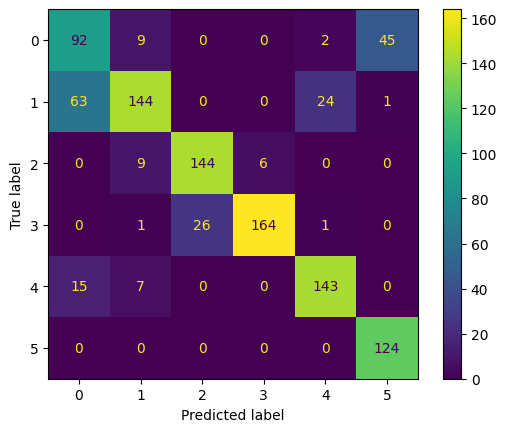

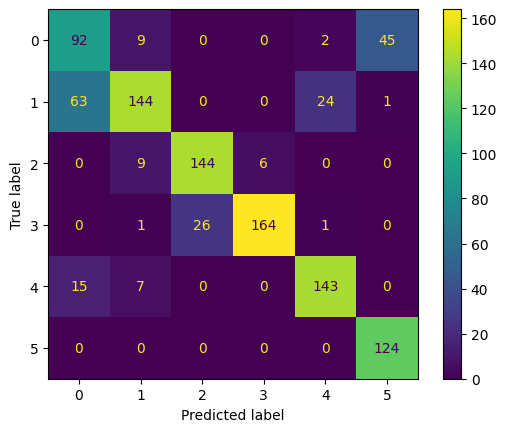

[KNN] Mean accuracy (3 runs): 0.7951. Mean f1-score: 0.7946



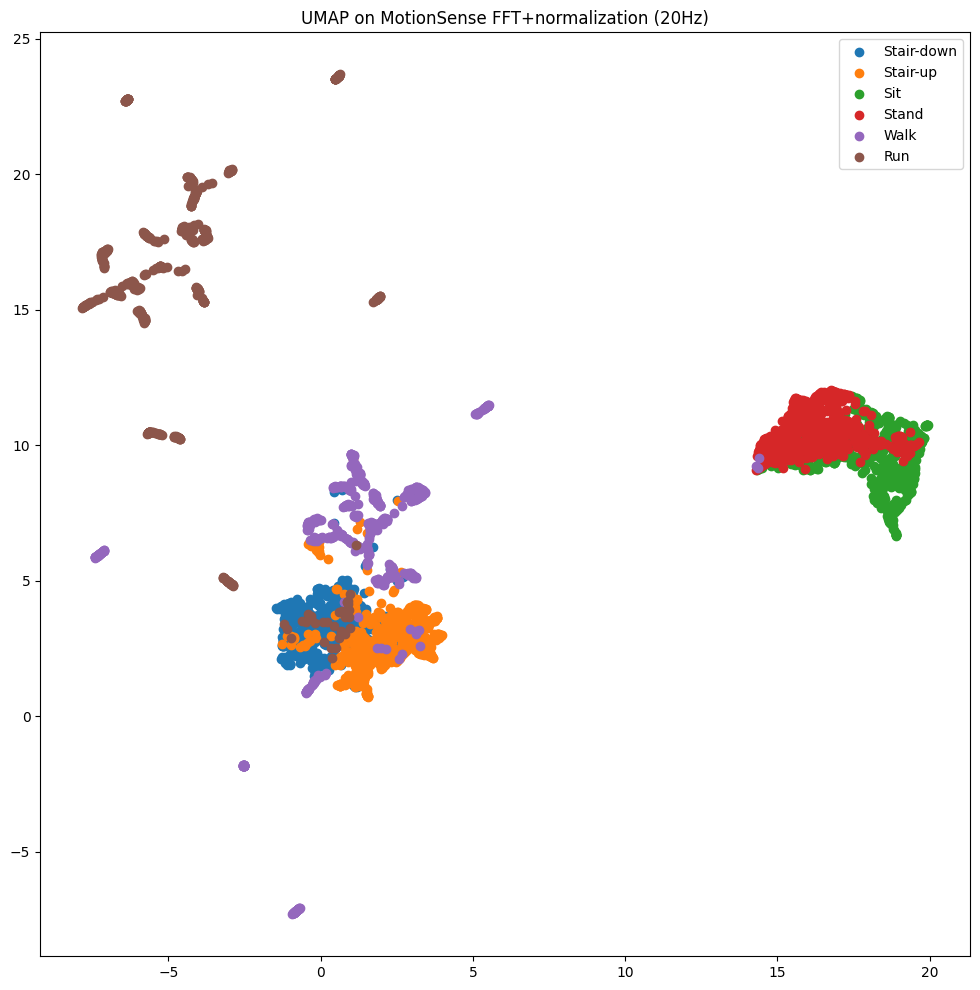

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


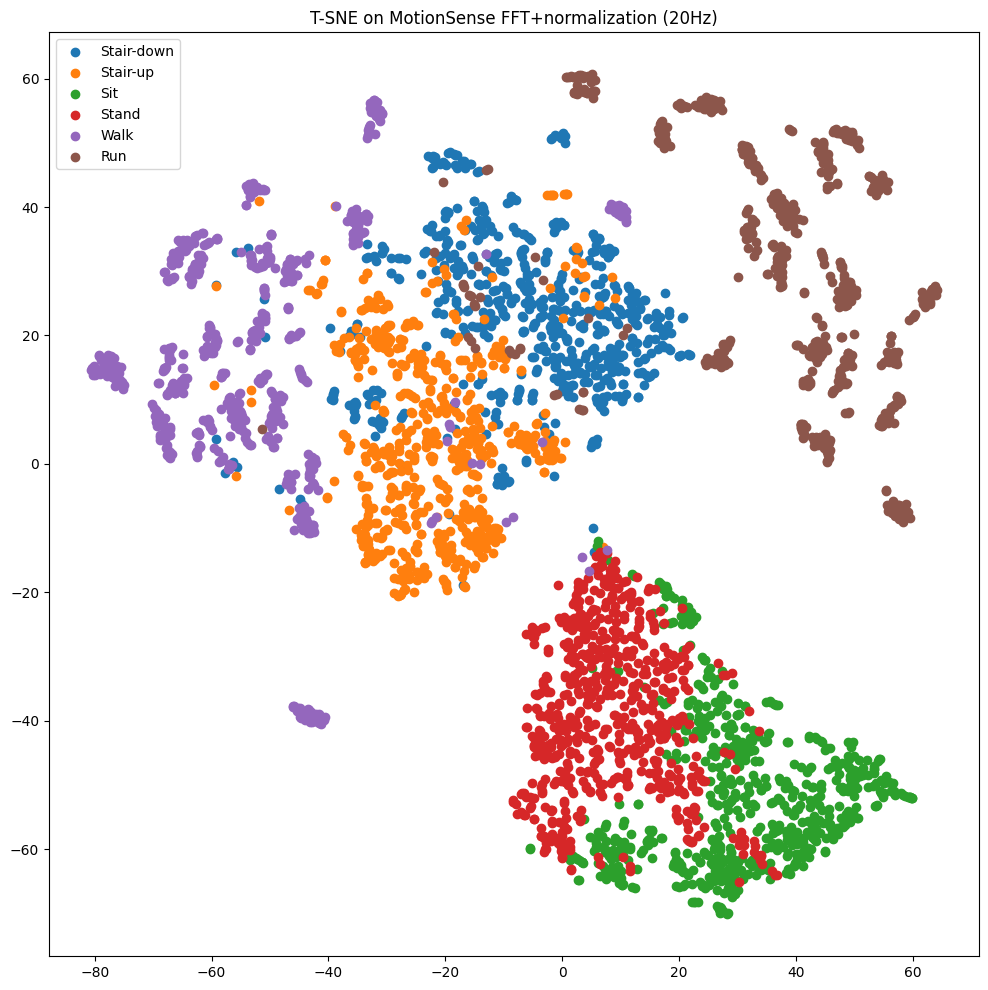

In [9]:
from librep.datasets.har.loaders import MotionSenseResampledView20HZ
activities = {
    0: "Stair-down",
    1: "Stair-up",
    2: "Sit",
    3: "Stand",
    4: "Walk",
    5: "Run"
}

loader = MotionSenseResampledView20HZ(
    "../data/views/MotionSense/resampled_view_20Hz", download=False
)
train_val, test = loader.load(concat_train_validation=True)
# train_val, test = do_resample(train_val, test)

train_val_fft_scaled, test_fft_scaled = transform_dataset(train_val, test, normalize="after")
evaluate_dataset(train_val_fft_scaled, test_fft_scaled)
project(train_val_fft_scaled, "MotionSense FFT+normalization (20Hz)", labels=activities)

## MotionSense (FFT only)

----------------- Random Forest -----------------


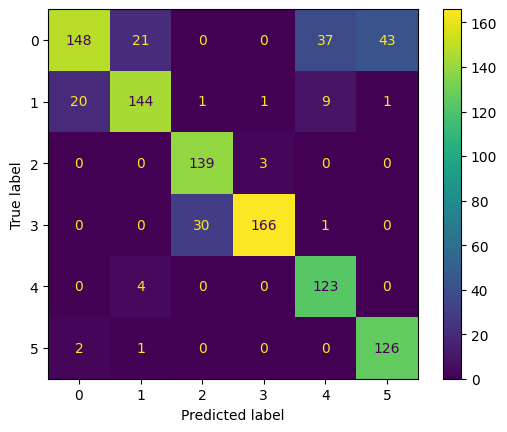

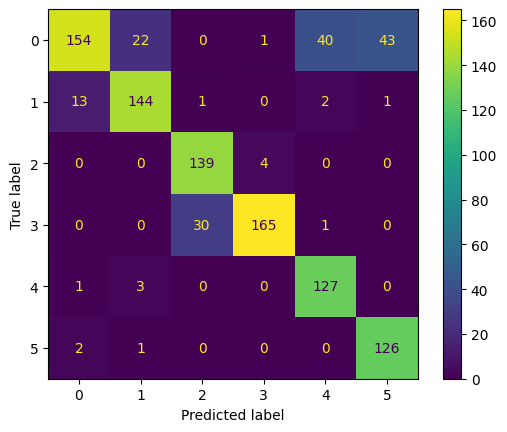

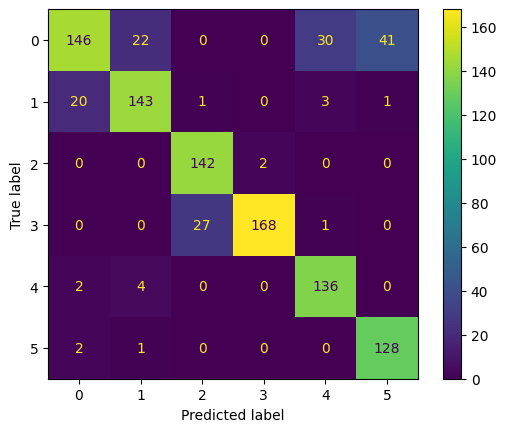

[RandomForest] Mean accuracy (3 runs): 0.8379. Mean f1-score: 0.8329

----------------- SVM -----------------


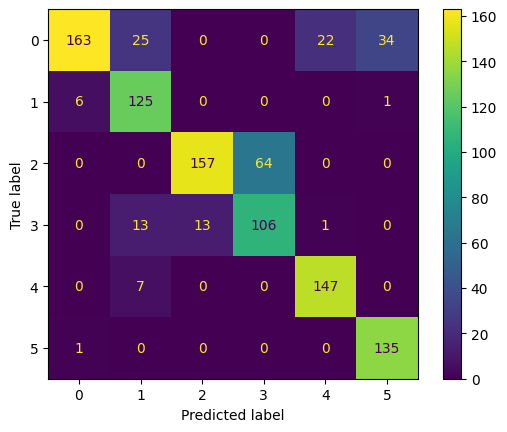

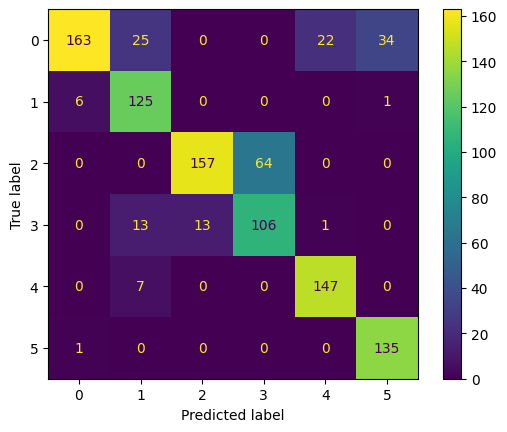

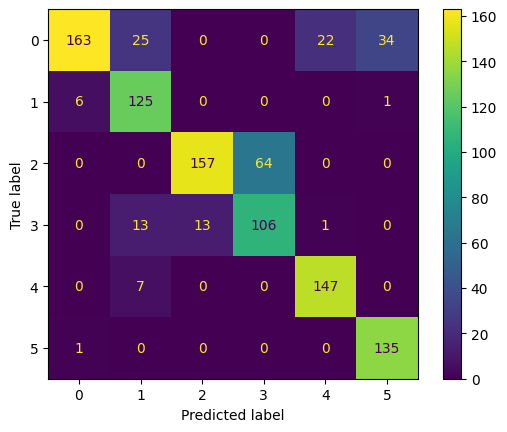

[SVM] Mean accuracy (3 runs): 0.8167. Mean f1-score: 0.8154

----------------- KNN -----------------


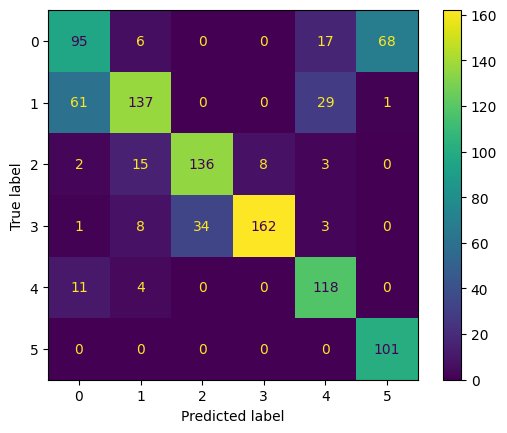

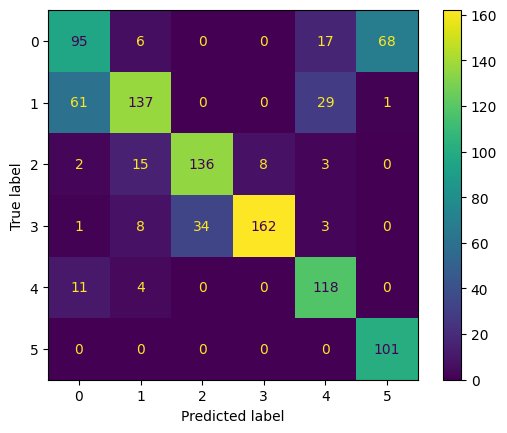

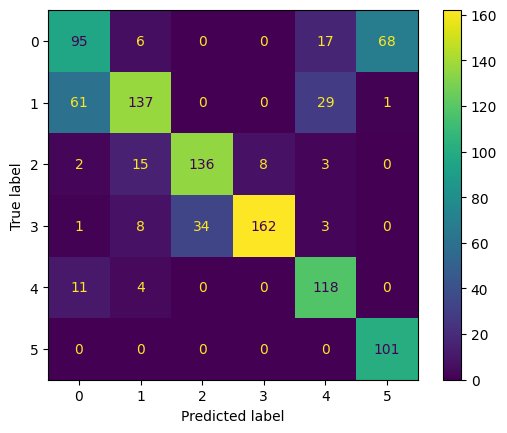

[KNN] Mean accuracy (3 runs): 0.7343. Mean f1-score: 0.7323



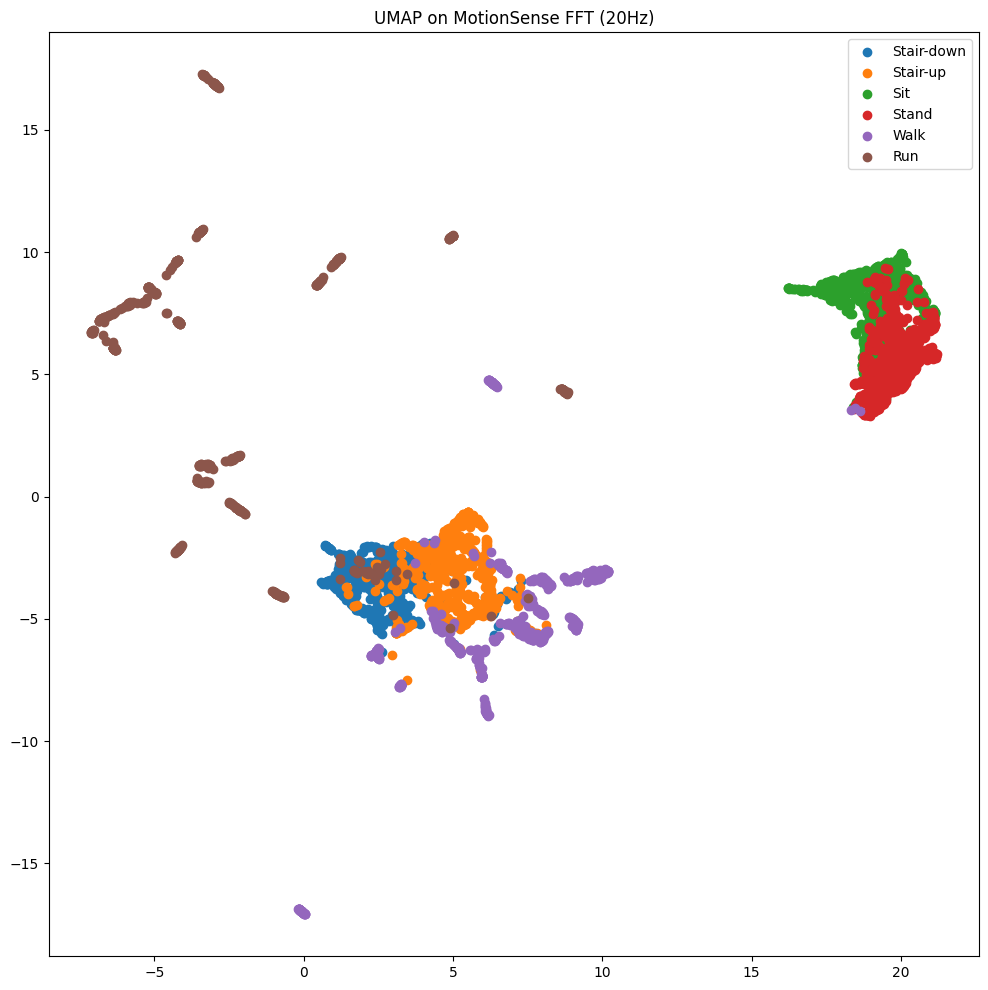

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


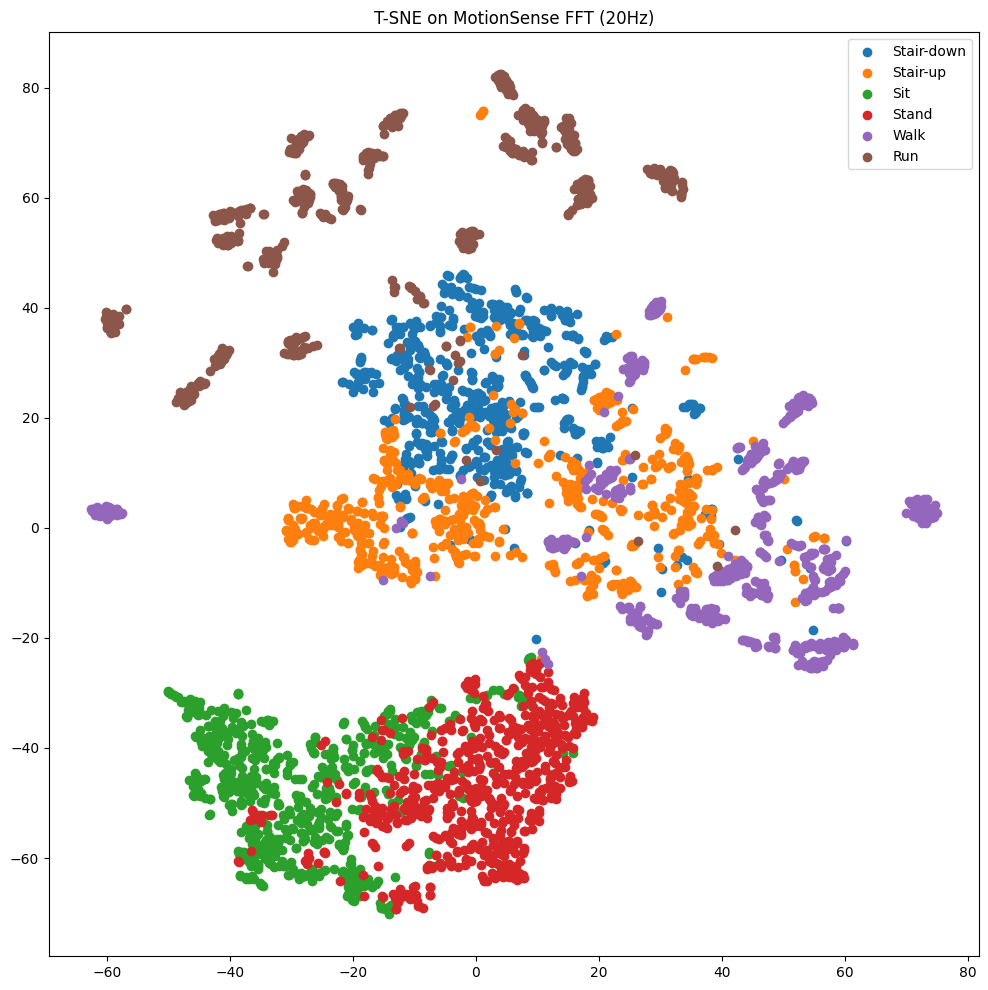

In [10]:
from librep.datasets.har.loaders import MotionSenseResampledView20HZ
activities = {
    0: "Stair-down",
    1: "Stair-up",
    2: "Sit",
    3: "Stand",
    4: "Walk",
    5: "Run"
}

loader = MotionSenseResampledView20HZ(
    "../data/views/MotionSense/resampled_view_20Hz", download=False
)
train_val, test = loader.load(concat_train_validation=True)
# train_val, test = do_resample(train_val, test)

train_val_fft_scaled, test_fft_scaled = transform_dataset(train_val, test, normalize=None)
evaluate_dataset(train_val_fft_scaled, test_fft_scaled)
project(train_val_fft_scaled, "MotionSense FFT (20Hz)", labels=activities)

## ExtraSensory (Normalization + FFT)

----------------- Random Forest -----------------


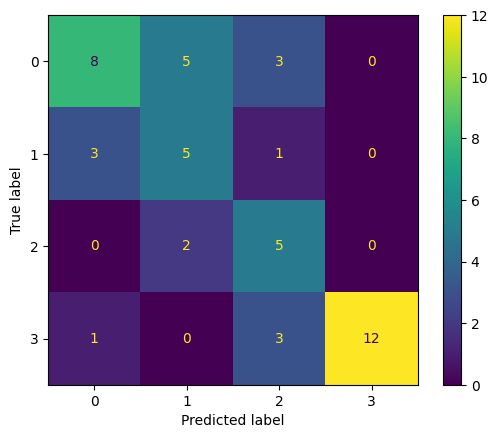

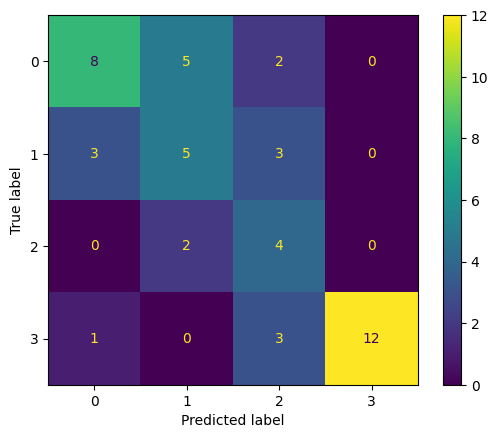

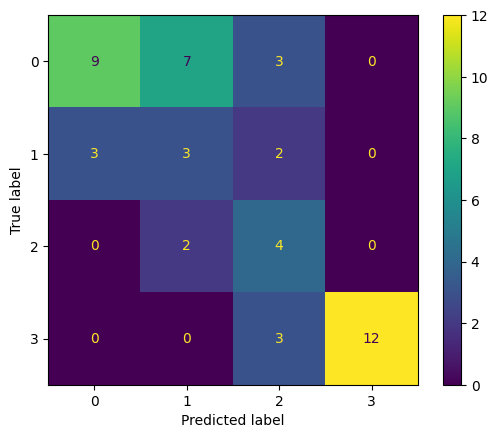

[RandomForest] Mean accuracy (3 runs): 0.6042. Mean f1-score: 0.6272

----------------- SVM -----------------


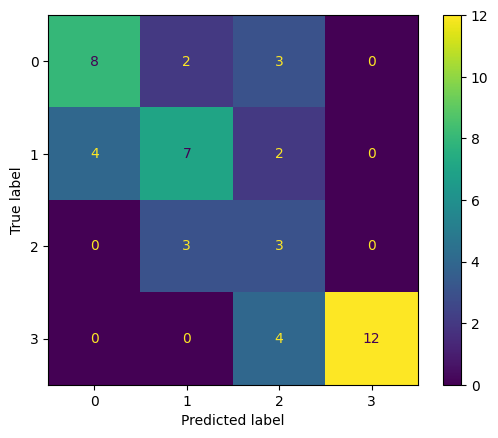

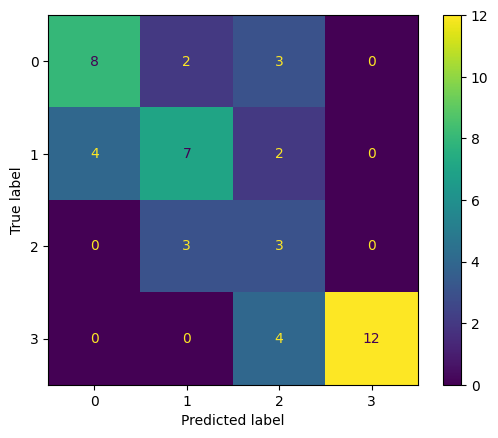

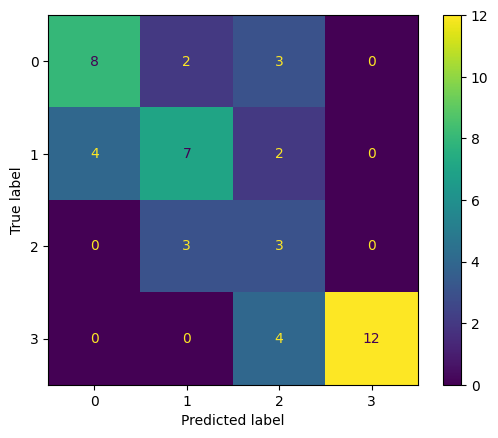

[SVM] Mean accuracy (3 runs): 0.6250. Mean f1-score: 0.6524

----------------- KNN -----------------


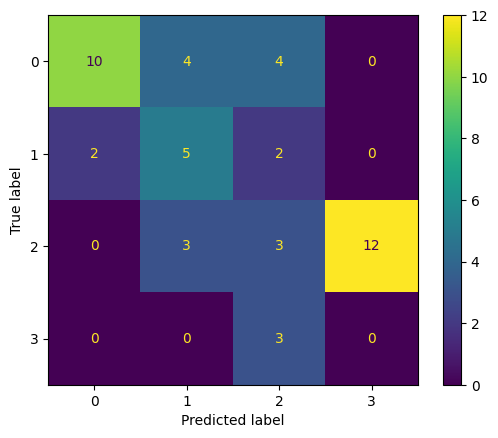

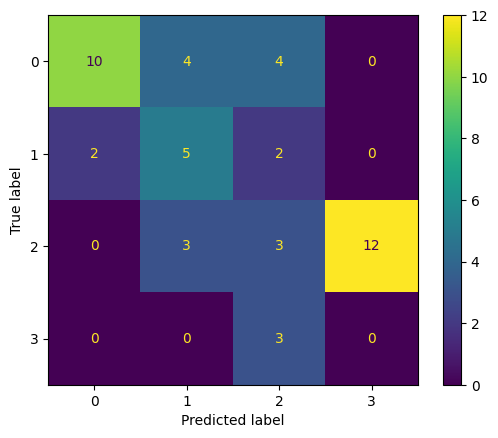

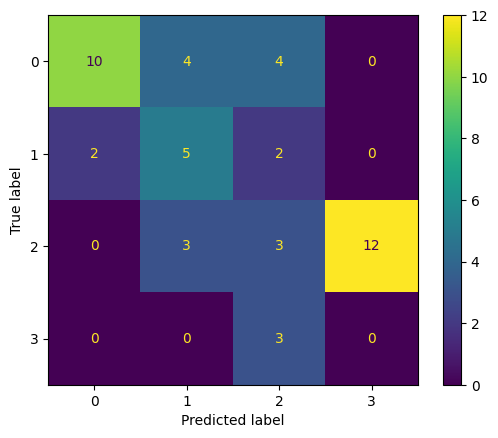

[KNN] Mean accuracy (3 runs): 0.3750. Mean f1-score: 0.4143



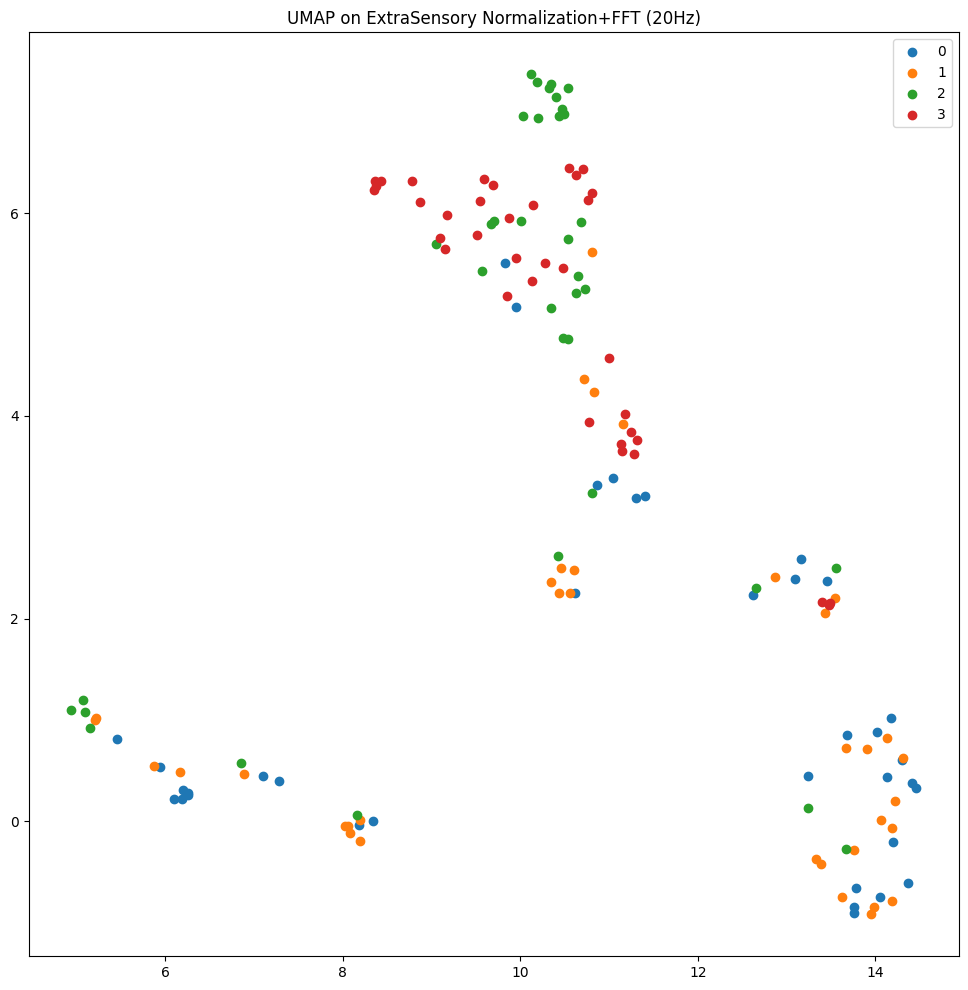

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


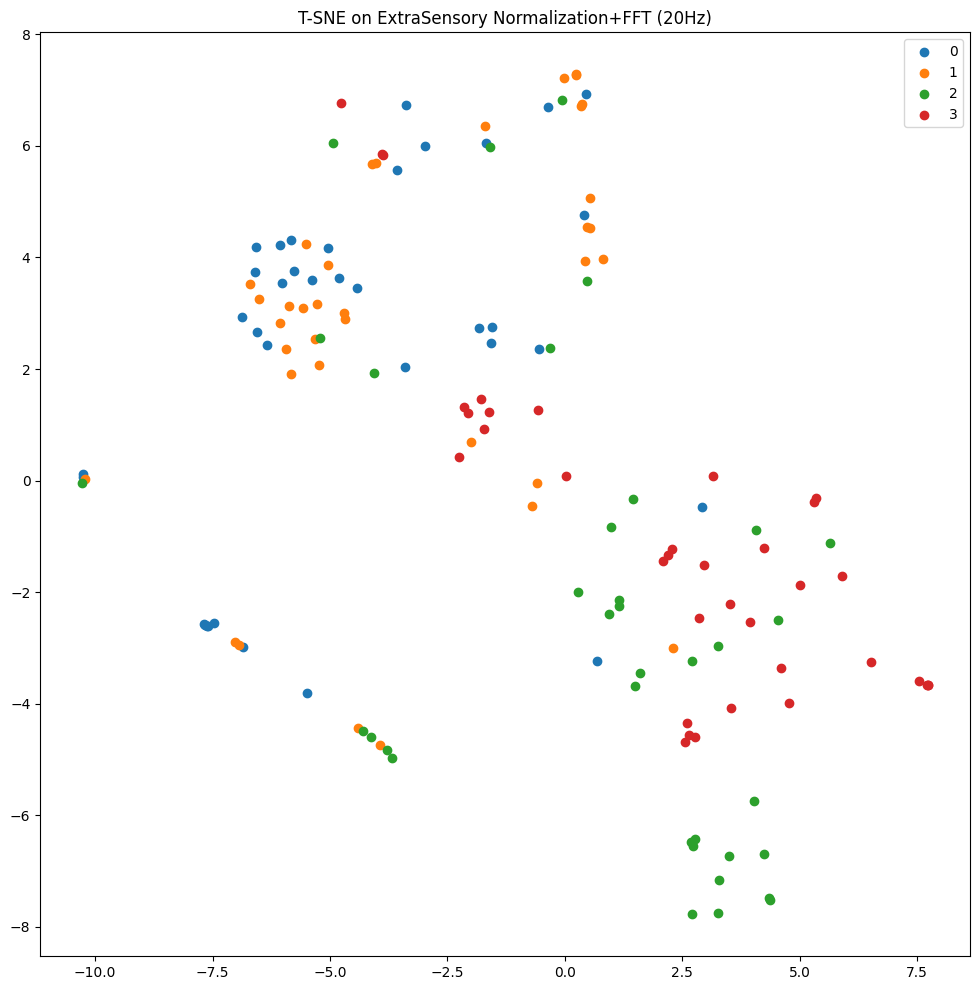

In [34]:
from librep.datasets.har.loaders import ExtraSensoryBalancedResampledView20HZ
activities = {
    0: "Stair-down",
    1: "Stair-up",
    2: "Sit",
    3: "Stand",
    4: "Walk",
    5: "Run"
}

loader = ExtraSensoryBalancedResampledView20HZ(
    "../data/views/ExtraSensory/balanced_view_resampled_20hz", download=False
)
train_val, test  = loader.load(concat_train_validation=True)
train_val, test = do_resample(train_val, test)

train_val_fft_scaled, test_fft_scaled = transform_dataset(train_val, test, normalize="before")
evaluate_dataset(train_val_fft_scaled, test_fft_scaled)
project(train_val_fft_scaled, "ExtraSensory Normalization+FFT (20Hz)", labels=None)

## ExtraSensory (FFT + Normalization)

----------------- Random Forest -----------------


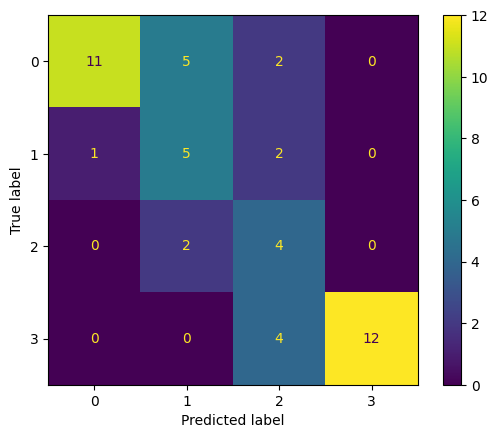

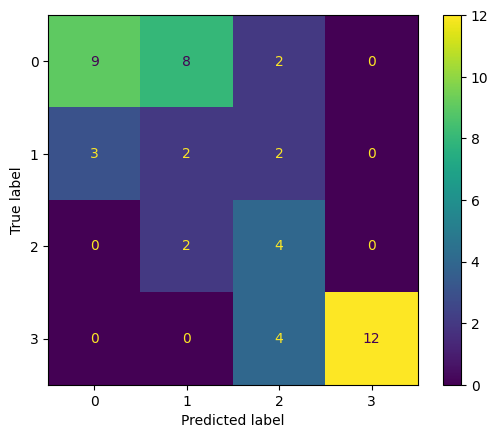

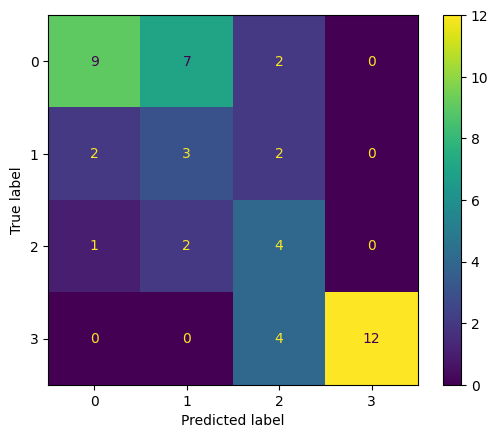

[RandomForest] Mean accuracy (3 runs): 0.6042. Mean f1-score: 0.6399

----------------- SVM -----------------


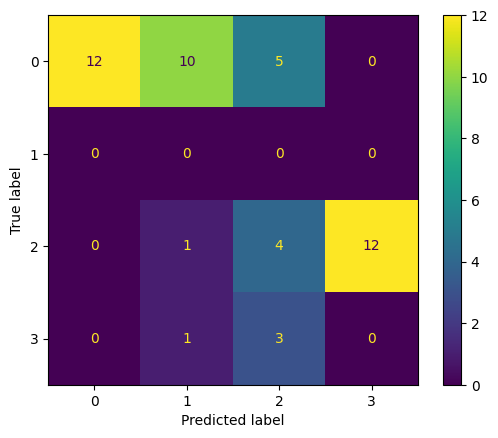

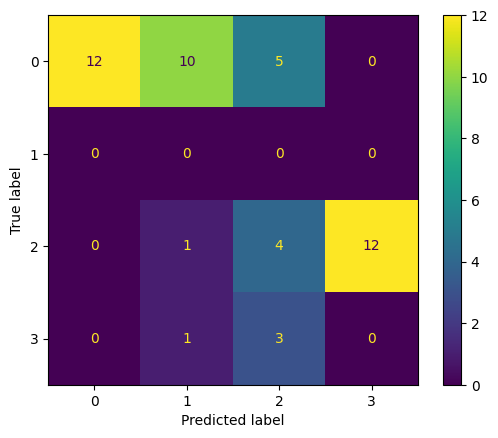

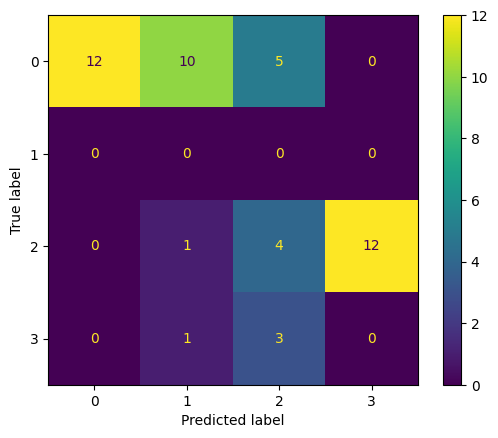

[SVM] Mean accuracy (3 runs): 0.3333. Mean f1-score: 0.4439

----------------- KNN -----------------


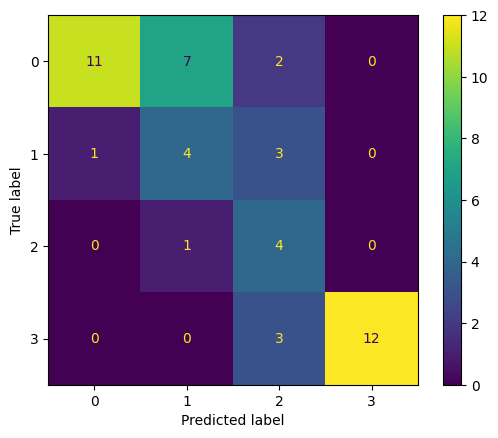

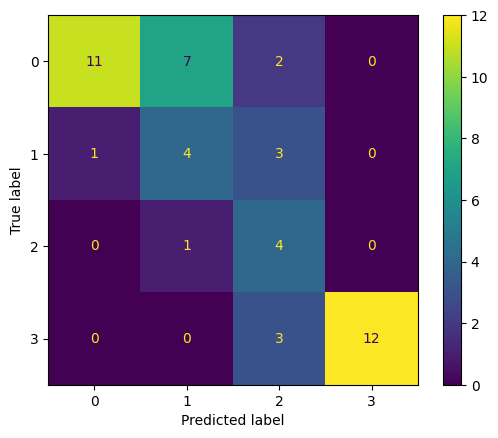

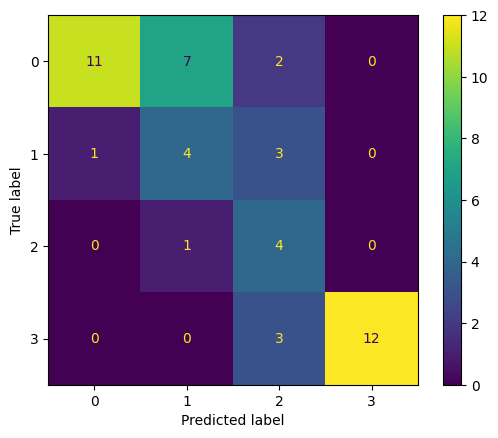

[KNN] Mean accuracy (3 runs): 0.6458. Mean f1-score: 0.6799



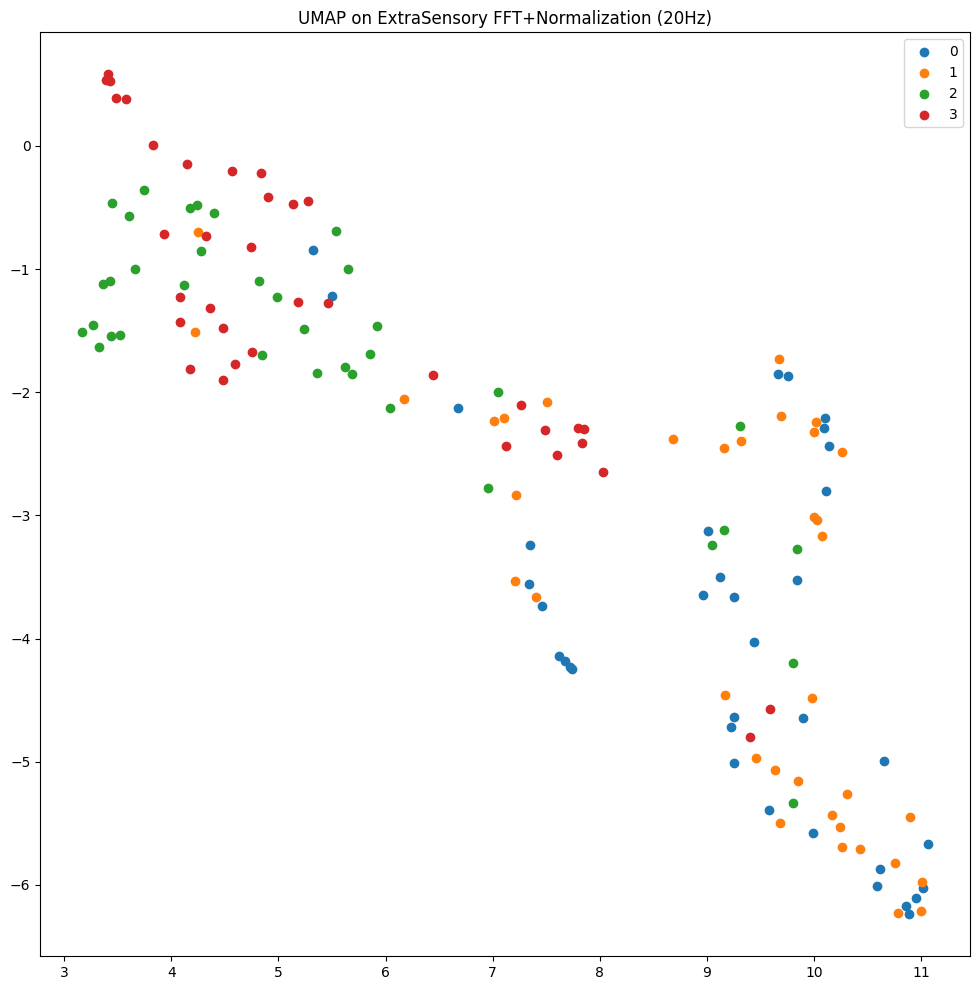

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


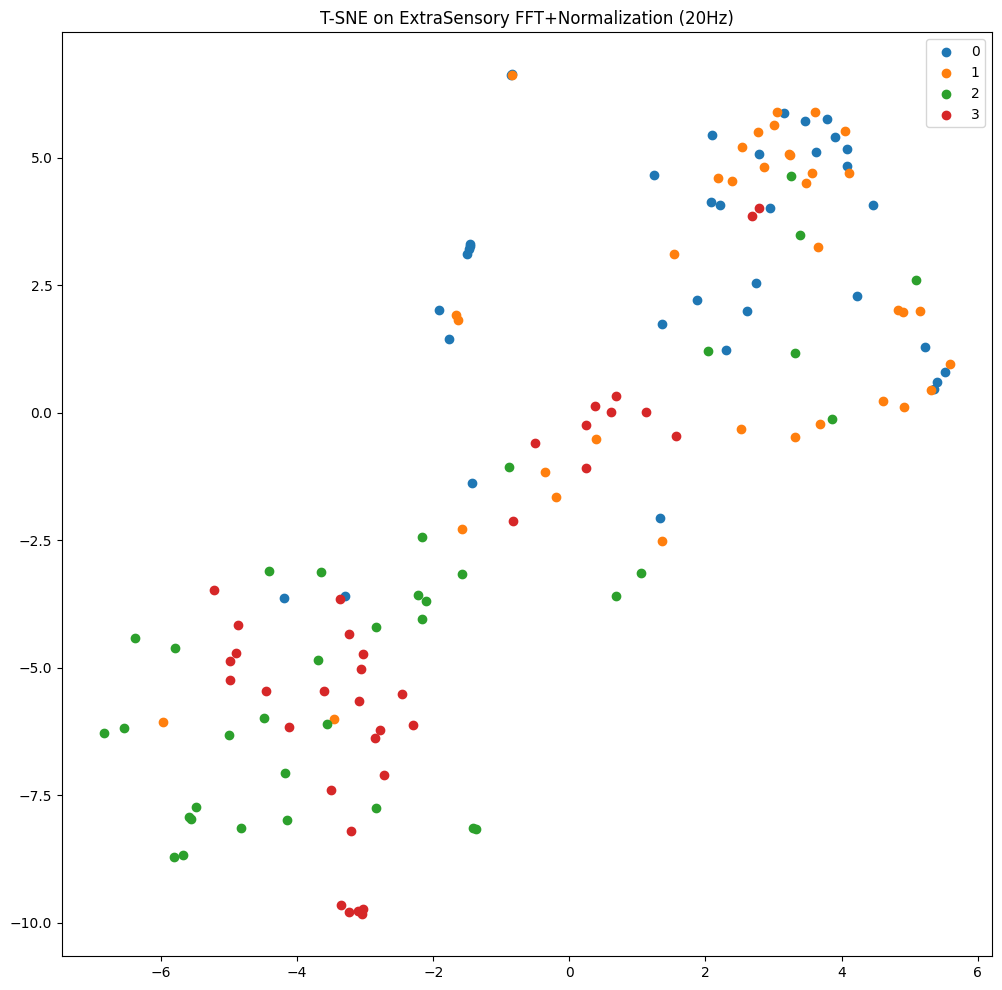

In [35]:
from librep.datasets.har.loaders import ExtraSensoryBalancedResampledView20HZ
activities = {
    0: "Stair-down",
    1: "Stair-up",
    2: "Sit",
    3: "Stand",
    4: "Walk",
    5: "Run"
}

loader = ExtraSensoryBalancedResampledView20HZ(
    "../data/views/ExtraSensory/balanced_view_resampled_20hz", download=False
)
train_val, test  = loader.load(concat_train_validation=True)
train_val, test = do_resample(train_val, test)

train_val_fft_scaled, test_fft_scaled = transform_dataset(train_val, test, normalize="after")
evaluate_dataset(train_val_fft_scaled, test_fft_scaled)
project(train_val_fft_scaled, "ExtraSensory FFT+Normalization (20Hz)", labels=None)

## ExtraSensory (FFT only)

----------------- Random Forest -----------------


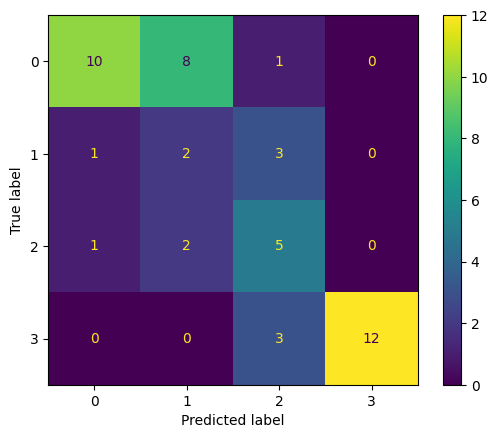

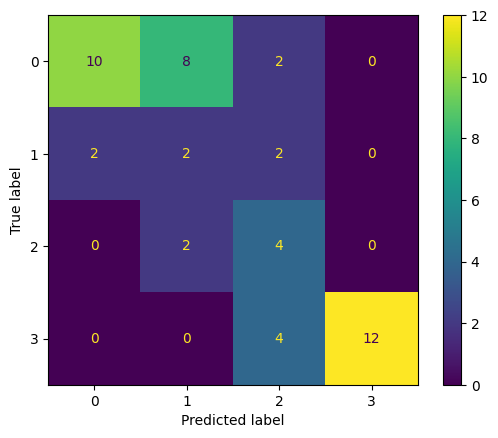

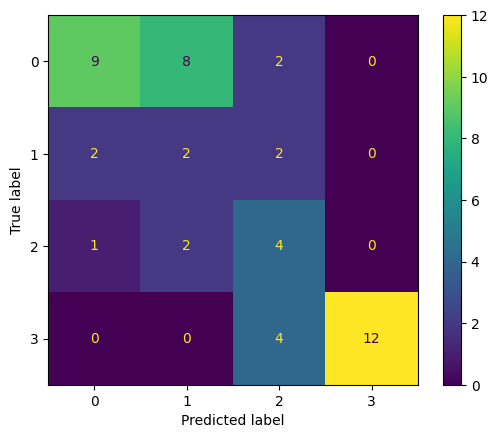

[RandomForest] Mean accuracy (3 runs): 0.5833. Mean f1-score: 0.6262

----------------- SVM -----------------


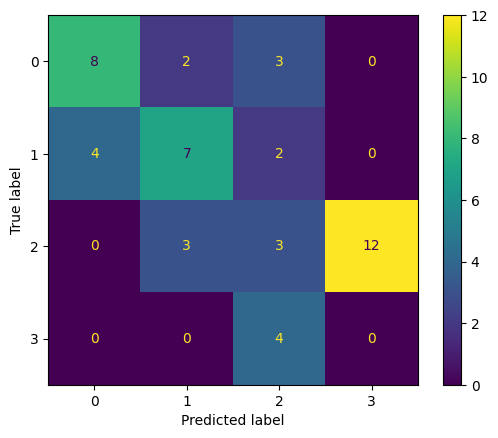

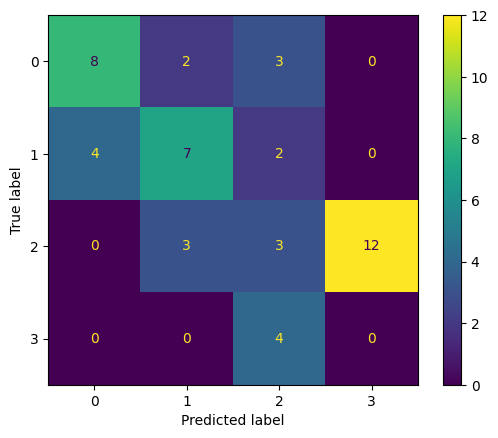

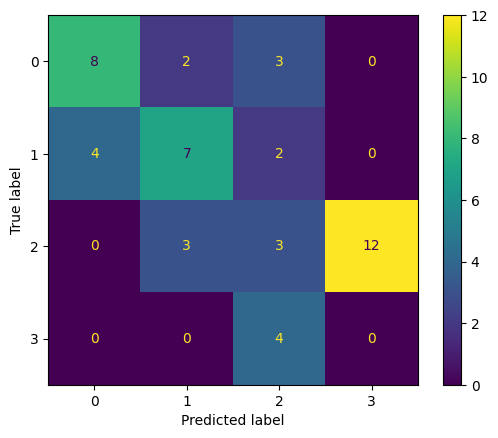

[SVM] Mean accuracy (3 runs): 0.3750. Mean f1-score: 0.4000

----------------- KNN -----------------


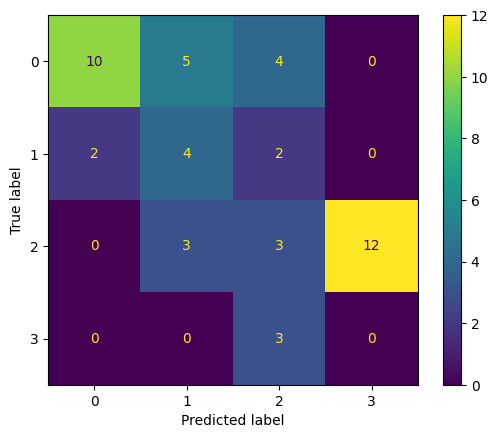

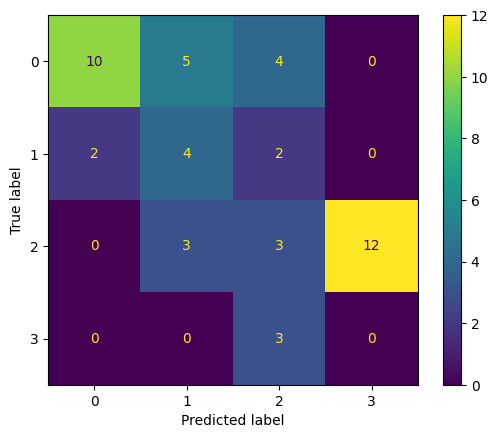

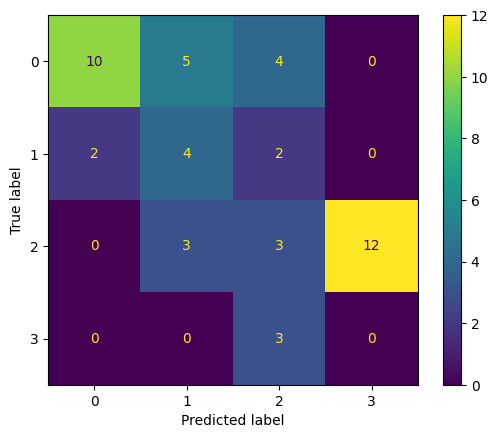

[KNN] Mean accuracy (3 runs): 0.3542. Mean f1-score: 0.3970



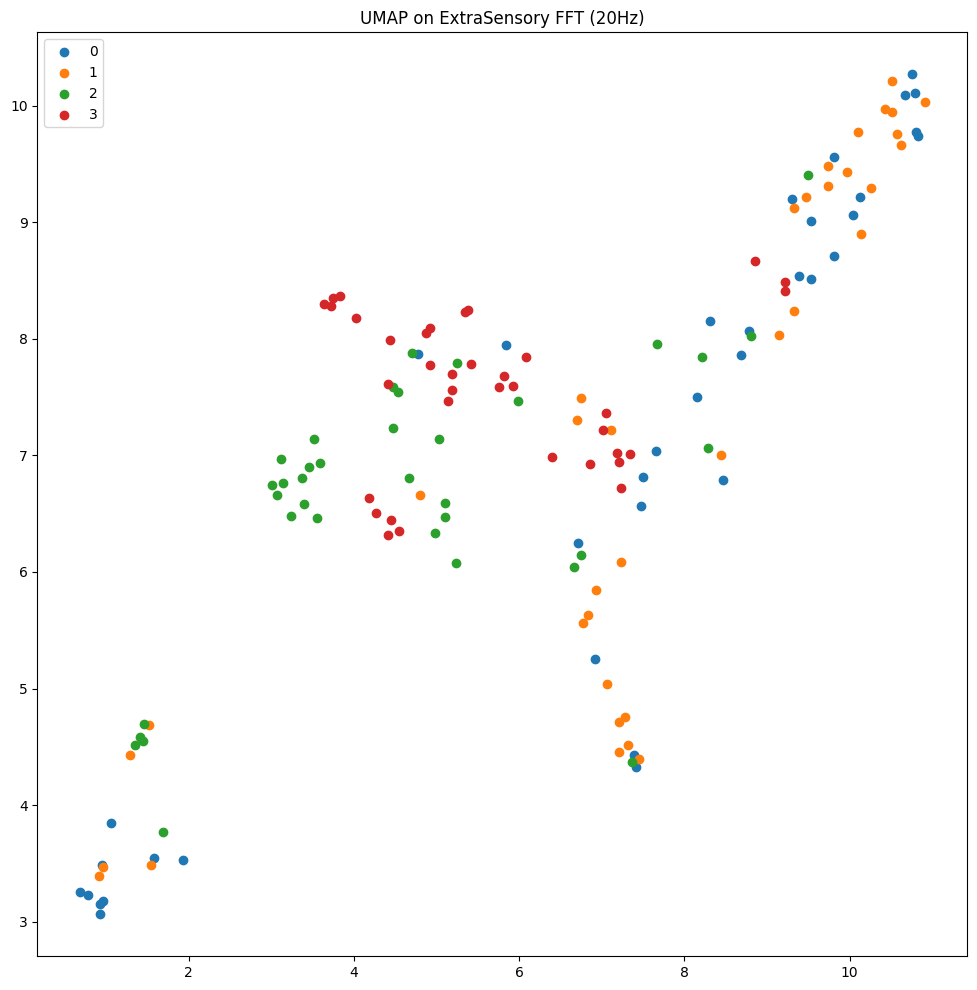

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


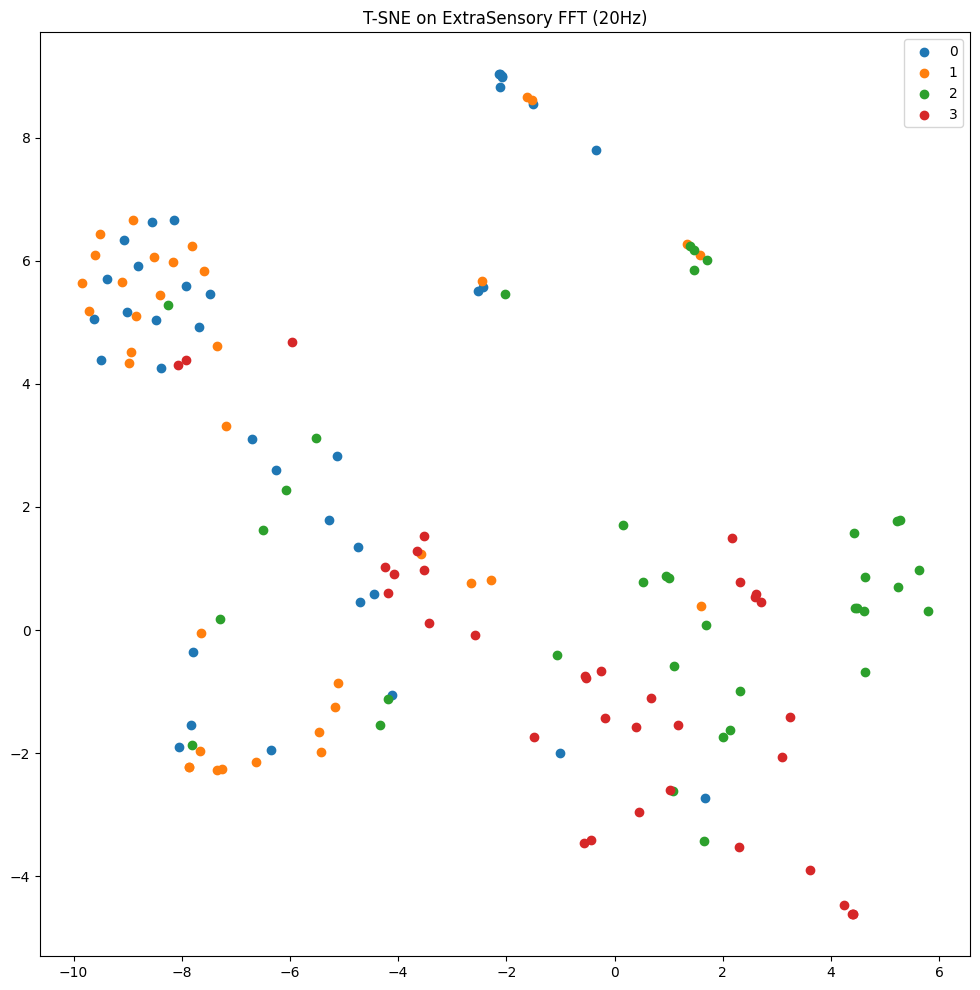

In [36]:
from librep.datasets.har.loaders import ExtraSensoryBalancedResampledView20HZ
activities = {
    0: "Stair-down",
    1: "Stair-up",
    2: "Sit",
    3: "Stand",
    4: "Walk",
    5: "Run"
}

loader = ExtraSensoryBalancedResampledView20HZ(
    "../data/views/ExtraSensory/balanced_view_resampled_20hz", download=False
)
train_val, test  = loader.load(concat_train_validation=True)
train_val, test = do_resample(train_val, test)

train_val_fft_scaled, test_fft_scaled = transform_dataset(train_val, test, normalize=None)
evaluate_dataset(train_val_fft_scaled, test_fft_scaled)
project(train_val_fft_scaled, "ExtraSensory FFT (20Hz)", labels=None)